# score 1,168,361.39014 얻은 노트북: 참가자 이경준
---
- 1~4 챕터까지는 노트북 순서대로 따라가면 되고, 5.는 맨밑의 main() 함수부터 위로 올라가면서 보면 됩니다.

# 목차
- [1. Import libs](#1.-Import-libs)
- [2. Read data](#2.-Read-data)
- [3. EDA & FE](#3.-EDA-%26amp%3B-FE)
    - [3.1 title : 영화의 제목](#3.1-title)
    - [3.2 distributor : 배급사](#3.2-distributor)
    - [3.3 genre : 장르](#3.3-genre)
    - [3.4 release_time : 개봉일](#3.4-release_time)
    - [3.5 time : 상영시간(분)](#3.5-time)
    - [3.6 screening_rat : 상영등급](#3.6-screening_rat)
    - [3.7 director : 감독이름](#3.7-director)
    - [3.8 dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수](#3.8-dir_prev_bfnum)
    - [3.9 dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수](#3.9-dir_prev_num)
    - [3.10 num_staff : 스테프수](#3.10-num_staff)
    - [3.11 num_actor : 주연배우수](#3.11-num_actor)
    - [3.12 feature cleanup](#3.12-feature-cleanup)
- [4. Data Preparation](#4.-Data-preparation)
- [5. Modelling & Learning](#5.-Modelling-%26amp%3B-Learning)
- [Epilogue](#Epilogue)

# 1. Import libs

In [1]:
import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import re
import gc
import timeit
from datetime import datetime

warnings.filterwarnings("ignore")

In [2]:
# 그래프에 한글표현.
plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams["font.size"] = 10
pd.options.display.float_format = '{:_.3f}'.format

# 2. Read data

In [3]:
start_time = timeit.default_timer()

In [4]:
train = pd.read_csv('./movies_train.csv')
test = pd.read_csv('./movies_test.csv')

train.head(5).T

,0,1,2,3,4
title,개들의 전쟁,내부자들,은밀하게 위대하게,나는 공무원이다,불량남녀
distributor,롯데엔터테인먼트,(주)쇼박스,(주)쇼박스,(주)NEW,쇼박스(주)미디어플렉스
genre,액션,느와르,액션,코미디,코미디
release_time,2012-11-22,2015-11-19,2013-06-05,2012-07-12,2010-11-04
time,96,130,123,101,108
screening_rat,청소년 관람불가,청소년 관람불가,15세 관람가,전체 관람가,15세 관람가
director,조병옥,우민호,장철수,구자홍,신근호
dir_prev_bfnum,NaN,1_161_602.500,220_775.250,23_894.000,1.000
dir_prev_num,0,2,4,2,1
num_staff,91,387,343,20,251


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
title             600 non-null object
distributor       600 non-null object
genre             600 non-null object
release_time      600 non-null object
time              600 non-null int64
screening_rat     600 non-null object
director          600 non-null object
dir_prev_bfnum    270 non-null float64
dir_prev_num      600 non-null int64
num_staff         600 non-null int64
num_actor         600 non-null int64
box_off_num       600 non-null int64
dtypes: float64(1), int64(5), object(6)
memory usage: 56.3+ KB


- **dir_prev_bfnum** 열에 (600-270=330개) **데이터 누락** 확인
---

In [6]:
train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
title,600,600,권법형사 : 차이나타운,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
distributor,600,169,CJ 엔터테인먼트,54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
genre,600,12,드라마,221,NaN,NaN,NaN,NaN,NaN,NaN,NaN
release_time,600,330,2015-10-22,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time,600.000,NaN,NaN,NaN,100.863,18.098,45.000,89.000,100.000,114.000,180.000
screening_rat,600,4,청소년 관람불가,204,NaN,NaN,NaN,NaN,NaN,NaN,NaN
director,600,472,홍상수,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dir_prev_bfnum,270.000,NaN,NaN,NaN,1_050_442.891,1_791_408.303,1.000,20_380.000,478_423.625,1_286_568.625,17_615_314.000
dir_prev_num,600.000,NaN,NaN,NaN,0.877,1.183,0.000,0.000,0.000,2.000,5.000
num_staff,600.000,NaN,NaN,NaN,151.118,165.655,0.000,17.000,82.500,264.000,869.000


- title은 중복없음.
- distributor는 169개의 다른 값을 가지고, 'CJ 엔..'가 54개로 가장 빈도가 많음.
- genre는 12개 분류고, '드라마' 장르가 가장 많음.
- release_time 패스.
- time은 평균 100.9분.
- screening_rat은 총 4개개 등급이고, 청관불이 가장 많음.
- director는 총 472명이고, '홍상수'가 가장 많음.
- **dir_prev_bfnum은 총 600개 중에 330개가 누락.**
- dir_prev_num은 최대가 5편, 중간값이 0편으로 데이터상 처녀작 감독이 과반.
- num_staff는 평균 151명.
- num_actor는 평균 4명.
- box_off_num의 평균은 708_182명.
---

In [7]:
test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
title,243,243,춘희막이,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
distributor,243,93,CJ 엔터테인먼트,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
genre,243,12,드라마,78,NaN,NaN,NaN,NaN,NaN,NaN,NaN
release_time,243,182,2012-11-22,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time,243.000,NaN,NaN,NaN,109.798,124.023,40.000,91.000,104.000,114.500,2_015.000
screening_rat,243,4,청소년 관람불가,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN
director,243,220,이정호,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dir_prev_bfnum,107.000,NaN,NaN,NaN,891_669.516,1_217_341.455,34.000,62_502.000,493_120.000,1_080_849.583,6_173_099.500
dir_prev_num,243.000,NaN,NaN,NaN,0.852,1.200,0.000,0.000,0.000,1.000,6.000
num_staff,243.000,NaN,NaN,NaN,159.317,162.977,0.000,18.000,105.000,282.000,776.000


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
title             243 non-null object
distributor       243 non-null object
genre             243 non-null object
release_time      243 non-null object
time              243 non-null int64
screening_rat     243 non-null object
director          243 non-null object
dir_prev_bfnum    107 non-null float64
dir_prev_num      243 non-null int64
num_staff         243 non-null int64
num_actor         243 non-null int64
dtypes: float64(1), int64(4), object(6)
memory usage: 21.0+ KB


- train/test 두 데이터 모두 **dir_prev_bfnum**에 데이터 결손이 50% 가까이 있음 --> feature 유효성 혹은 결측치를 채우는 방법에 대한 고민 필요.
---

In [9]:
total = pd.concat([train, test], ignore_index=True)
total.tail().T

,838,839,840,841,842
box_off_num,NaN,NaN,NaN,NaN,NaN
dir_prev_bfnum,2_590.000,NaN,NaN,50_699.000,NaN
dir_prev_num,1,0,0,1,0
director,안슬기,이일하,안용훈,송동윤,이전
distributor,디씨드,인디스토리,(주)컨텐츠온미디어,(주)씨타마운틴픽쳐스,(주) 케이알씨지
genre,드라마,다큐멘터리,느와르,드라마,멜로/로맨스
num_actor,4,2,4,7,4
num_staff,4,18,224,68,10
release_time,2015-11-19,2015-10-29,2015-10-28,2015-10-22,2015-10-22
screening_rat,15세 관람가,12세 관람가,청소년 관람불가,청소년 관람불가,청소년 관람불가


- 데이터 처리를 한꺼번에 하기 위해서, train과 test를 하나의 데이터프레임으로 묶음.
- **box_off_num열의 값이 NaN이냐에 따라 train/test 데이터셋 구분 가능.**
---

# 3. EDA & FE
## 3.1 title

- 영화의 제목은, 관객들이 외우거나 칭하는 도구로서 항간에는 영화제목의 글자수와 흥행에 관한 속설(즉, 어느 정도 연관이 있음을 의미)도 있기에
이를 feature로 포착. 이때, 가령 제목 '개들의 전쟁'은 프로그래밍상의 문자열로는 6이지만, 위의 속설과 관계해선 (개/들/의/전/쟁) 식으로
글자수를 계산하는 한국(어)적인 특성을 반영해, 공백/쉼표 등을 제거하고 계산. 다만, 숫자 등 좀더 복잡한 케이스는 따로 고려치 않았음.
- 즉, **제목(문자열) --> 제목수(숫자/길이)**로 피처 변경 시도.

In [10]:
def title_length(s):
    s = re.sub('[^\w]', '', s) # 공백제거
    return len(s)

total['title_length'] = total['title'].apply(title_length)
total.head(3).T

,0,1,2
box_off_num,23_398.000,7_072_501.000,6_959_083.000
dir_prev_bfnum,NaN,1_161_602.500,220_775.250
dir_prev_num,0,2,4
director,조병옥,우민호,장철수
distributor,롯데엔터테인먼트,(주)쇼박스,(주)쇼박스
genre,액션,느와르,액션
num_actor,2,3,4
num_staff,91,387,343
release_time,2012-11-22,2015-11-19,2013-06-05
screening_rat,청소년 관람불가,청소년 관람불가,15세 관람가


In [11]:
total = total.rename(columns = {'title':'DROP_title'}) # 모든 처리가 끝난 후에, 제거할 열의 이름은 DROP_ 추가.
total.head().T

,0,1,2,3,4
box_off_num,23_398.000,7_072_501.000,6_959_083.000,217_866.000,483_387.000
dir_prev_bfnum,NaN,1_161_602.500,220_775.250,23_894.000,1.000
dir_prev_num,0,2,4,2,1
director,조병옥,우민호,장철수,구자홍,신근호
distributor,롯데엔터테인먼트,(주)쇼박스,(주)쇼박스,(주)NEW,쇼박스(주)미디어플렉스
genre,액션,느와르,액션,코미디,코미디
num_actor,2,3,4,6,2
num_staff,91,387,343,20,251
release_time,2012-11-22,2015-11-19,2013-06-05,2012-07-12,2010-11-04
screening_rat,청소년 관람불가,청소년 관람불가,15세 관람가,전체 관람가,15세 관람가


- 제목(title)은 feature로 사용될 때는 제목수(title_length)만 이용되는데, 중간중간 데이터 확인/처리 등의 목적을 위해, 바로 컬럼을 DROP시키지 않고, DROP_title이라는 임시 컬럼명으로 변경한 후, 모든 정리가 끝나고 러닝에 들어가기 전에 "DROP_"이 붙은 컬럼들을 일괄 삭제하기 위한 조치. 가령 제목 같은 데이터는 자주 (사람이) 데이터 확인시에 사용되는 항목이기에, title을 바로 제거해버리면, 차후 데이터 확인(head/tail) 등시에 비교에 어려움이 있다. 
---

- 제목수에 대한 관객수의 분포를 그려본다.

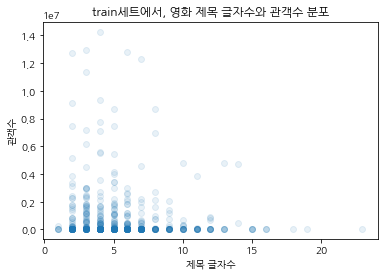

In [12]:
plt.scatter(total.title_length, total.box_off_num, alpha=0.1)
plt.xlabel('제목 글자수')
plt.ylabel('관객수')
plt.title('train세트에서, 영화 제목 글자수와 관객수 분포')
plt.show()

In [13]:
total.title_length.max(), total.title_length.min()

(23, 1)

- 제목수와 관객수에 어느 정도 관련성이 나타난다고 볼 수 있다(완전 랜덤하지 않다). **다만, 제목수가 1에서 23까지 폭이 넓기에, 이를 특정 구간으로 나눠서 구분한다.**
- 제목수 **1**은 2이상과 타겟값에서 많이 차이가 나므로, 길이 1을 하나의 구간으로 선정.
- 제목수 **2,3,4,5**를 하나의 구간.
- 제목수 **6,7,8,9**를 또하나의 구간.
- 제목수 **10 이상**을 마지막 구간, 총 4개의 구간으로 나눔.
- (위 구간선정은 그래프를 보고 직관적으로 선정했음. 나름 기준은, 각 구간내 값의 편차가 크지 않고, 총 구간수가 너무 많지 않을 것 정도.)
---

- title_length를 bins 값을 기준구간으로 해서, title_length가 속하는 구간을 값으로 하는 새로운 title_length_category열 생성.

In [14]:
bins = pd.IntervalIndex.from_tuples([(0,1), (1,5), (5,9), (9,23)]) # 0<x<=1, 1<x<=5, 5<x<=9, 9<x<=23 (1/2~5/6~9/10~)
total['title_length_category'] = pd.cut(total.title_length, bins)
total.title_length_category[:5]

0    (1, 5]
1    (1, 5]
2    (5, 9]
3    (5, 9]
4    (1, 5]
Name: title_length_category, dtype: category
Categories (4, interval[int64]): [(0, 1] < (1, 5] < (5, 9] < (9, 23]]

In [15]:
total = total.rename(columns = {'title_length':'DROP_title_length'})
total.head().T

,0,1,2,3,4
box_off_num,23_398.000,7_072_501.000,6_959_083.000,217_866.000,483_387.000
dir_prev_bfnum,NaN,1_161_602.500,220_775.250,23_894.000,1.000
dir_prev_num,0,2,4,2,1
director,조병옥,우민호,장철수,구자홍,신근호
distributor,롯데엔터테인먼트,(주)쇼박스,(주)쇼박스,(주)NEW,쇼박스(주)미디어플렉스
genre,액션,느와르,액션,코미디,코미디
num_actor,2,3,4,6,2
num_staff,91,387,343,20,251
release_time,2012-11-22,2015-11-19,2013-06-05,2012-07-12,2010-11-04
screening_rat,청소년 관람불가,청소년 관람불가,15세 관람가,전체 관람가,15세 관람가


- catergorical 형식으로 된 title_length_category열의 값을 one-hot-encoding으로 변환.
    - 사실 4. Data Preparation 과정에서 total 데이터프레임에 대해 카테고리형식을 원핫인코딩으로 일괄변환하는 과정이 있다.
    - 이 노트북 초반에는 후반의 그 과정(Ch.4)에 대해 생각지 못하고, 그때그때 적용하다보니, 원핫인코딩이 아래처럼 개별 컬럼 처리과정에서 행해지기도 하고 있다.

In [16]:
total = pd.get_dummies(total, columns=['title_length_category'], prefix=['title'])
total.head().T

,0,1,2,3,4
box_off_num,23_398.000,7_072_501.000,6_959_083.000,217_866.000,483_387.000
dir_prev_bfnum,NaN,1_161_602.500,220_775.250,23_894.000,1.000
dir_prev_num,0,2,4,2,1
director,조병옥,우민호,장철수,구자홍,신근호
distributor,롯데엔터테인먼트,(주)쇼박스,(주)쇼박스,(주)NEW,쇼박스(주)미디어플렉스
genre,액션,느와르,액션,코미디,코미디
num_actor,2,3,4,6,2
num_staff,91,387,343,20,251
release_time,2012-11-22,2015-11-19,2013-06-05,2012-07-12,2010-11-04
screening_rat,청소년 관람불가,청소년 관람불가,15세 관람가,전체 관람가,15세 관람가


**∴** 영화제목(문자열)에 한국식 글자수 세는 법을 적용해, 제목길이로 변경한 후, 1~23까지의 폭이 큰 제목길이를, 제목길이에 대한 영화관객수 데이터를 기준으로, 비슷한 값의 분포를 가지는 4구간으로 길이를 나눠서 단순화 시킨후, 이를 one-hot-encoding했음.

## 3.2 distributor
배급사는 영화 상영관 확보 등 여러면에서 관객 동원에 영향이 있다고 볼 수 있음.

In [17]:
len(train.distributor.unique()), len(test.distributor.unique()) #train/test 데이터셋의 배급사 갯수.

(169, 93)

혹시 test 세트 데이터 중에서 train세트의 distributor에 없는 배급사가 포함되어 있는지 확인.

In [18]:
d1 = train.distributor
d2 = test.distributor

print('test 세트에만 존재하는 distributor의 수 =', len(list(set(d2) - set(d1))))

test 세트에만 존재하는 distributor의 수 = 35


In [19]:
print(list(set(d2) - set(d1))) # test 세트에만 존재하는 distributor

['리아코어콘텐츠', '마운틴픽쳐스', '리얼라이즈픽쳐스', '(유)영화사 화수분', '갑종필름', '(주)씨타마운틴픽쳐스', '프리비젼', '와우픽쳐스', '(주)영화사 빅', '롯데쇼핑(주)롯데엔터테인먼트', '굿픽처스', '(주)루믹스미디어', '명필름', '메가박스중앙(주)플러스엠', '비에이치제이 시네마', '핑크로봇 필름', '유나이티드 픽처스', '(주)루스이소니도스', '미로비젼', '(주)컨텐츠온미디어', '(주)드림웨스트픽쳐스', '(주)디씨드', '모쿠슈라', '늘푸른시네마', '노근리 프로덕션', '(주)다세포클럽', '디씨드', 'Cinema SAM', '필마픽쳐스', '타임스토리', '미디어로그', '청년필름', '애니메이션 배급', '오픈유컬쳐', '레몬트리']


In [20]:
dist1 = pd.Series(total.distributor.unique()) # train/test 전체 데이터세트에 포함된 배급사 목록.
print('Unique distributor size =' , len(dist1))
print(dist1.values) # 단순히, 컴팩트하게 배급사를 화면에 표시하기 위해 시리즈가 아닌 리스트로 값 출력.

Unique distributor size = 204
['롯데엔터테인먼트' '(주)쇼박스' '(주)NEW' '쇼박스(주)미디어플렉스' '백두대간' '유니버설픽쳐스인터내셔널코리아'
 '(주)두타연' '(주) 케이알씨지' '(주)콘텐츠 윙' '(주)키노아이' '(주)팝 파트너스' 'CJ E&M 영화부문'
 '(주) 영화제작전원사' 'CJ E&M Pictures' 'CGV 무비꼴라쥬' '리틀빅픽처스' '스폰지' 'CJ 엔터테인먼트'
 'CGV아트하우스' '조이앤시네마' '인디플러그' '콘텐츠판다' '인디스토리' '(주)팝엔터테인먼트' '시네마서비스' '웃기씨네'
 '영화사 진진' '(주)레인보우 팩토리' '김기덕 필름' 'NEW' 'CJ CGV' '동국대학교 충무로영상제작센터'
 'BoXoo 엔터테인먼트' '(주)마운틴픽쳐스' 'CGV 아트하우스' '메가박스(주)플러스엠' '골든타이드픽처스' '파이오니아21'
 '디 씨드' '드림팩트 엔터테인먼트' '시너지' '디마엔터테인먼트' '판다미디어' '(주)스톰픽쳐스코리아'
 '(주)예지림 엔터테인먼트' '(주) 영화사조제' '보람엔터테인먼트' '(주)시네마달' '노바엔터테인먼트' '(주)패스파인더씨앤씨'
 '(주)대명문화공장' '(주)온비즈넷' 'KT&G 상상마당' '무비꼴라쥬' '인벤트 디' '씨네그루(주)키다리이엔티'
 '스튜디오후크' '시네마 달' '나이너스엔터테인먼트(주)' 'THE 픽쳐스' '영구아트무비' '리틀빅픽쳐스' '어뮤즈'
 '이모션 픽처스' '(주)이스트스카이필름' '필라멘트 픽쳐스' '조이앤컨텐츠그룹' '타임스토리그룹' '마운틴 픽처스'
 '(주)휘엔터테인먼트' '이십세기폭스코리아(주)' '(주)피터팬픽쳐스' '에스와이코마드' '(주)더픽쳐스' '오퍼스픽쳐스'
 '(주)고앤고 필름' '사람과 사람들' '(주)JK필름' '씨너스엔터테인먼트(주)' 'KT' '싸이더스FNH' '(주)프레인글로벌'
 '나우콘텐츠' '홀리가든' '(주) 브릿지웍스' '(주)엣나인필름' '위더스필름' '시네마달' '(주)에이원

- **배급사의 표기에 단순오기, 혹은 회사명의 변경 등의 이유로 같은 회사를 다르게 표기한 경우가 없는지 확인.**

In [21]:
def tidy_distributor(x):
    return x.replace('(주)', '').replace('(유)', '').replace(' ', '') # '(주)회사명', '(유)회사명'에서 (주)/(유) 표시와 공백을 제거.

# 전체 데이터셋의 distributor 값을 정리해서 dist2에 담는다.
dist2 = dist1.apply(tidy_distributor).unique()
print('Unique distributor size =' , len(dist2))
print(np.sort(dist2))

Unique distributor size = 191
['BoXoo엔터테인먼트' 'CGV무비꼴라쥬' 'CGV아트하우스' 'CJCGV' 'CJE&MPictures' 'CJE&M영화부문'
 'CJ엔터테인먼트' 'CinemaSAM' 'JK필름' 'KBS미디어' 'KT' 'KT&G상상마당' 'M2픽처스' 'NEW'
 'OAL(올)' 'SBS콘텐츠허브' 'SK텔레콤' 'SK플래닛' 'THE픽쳐스' 'tvN' 'ysfilm' '갑종필름' '건시네마'
 '고구마공작소' '고앤고필름' '골든타이드픽처스' '굿픽처스' '김기덕필름' '나우콘텐츠' '나이너스엔터테인먼트' '노근리프로덕션'
 '노바엔터테인먼트' '노버스엔터테인먼트' '늘푸른시네마' '다세포클럽' '대명문화공장' '더피플' '더픽쳐스'
 '더픽쳐스/마운틴픽쳐스' '동국대학교충무로영상제작센터' '두엔터테인먼트' '두타연' '드림로드' '드림웨스트픽쳐스'
 '드림팩트엔터테인먼트' '디마엔터테인먼트' '디씨드' '랠리버튼' '레몬트리' '레인보우팩토리' '로드하우스' '롤러코스터프로덕션'
 '롯데쇼핑롯데엔터테인먼트' '롯데엔터테인먼트' '루믹스미디어' '루스이소니도스' '리아코어콘텐츠' '리얼라이즈픽쳐스'
 '리틀빅픽처스' '리틀빅픽쳐스' '마노엔터테인먼트' '마법사필름' '마운틴픽처스' '마운틴픽쳐스' '마인스엔터테인먼트'
 '머스트씨무비' '메가박스중앙플러스엠' '메가박스플러스엠' '명필름' '모쿠슈라' '무비꼴라쥬' '미디어데이' '미디어로그'
 '미라클필름' '미로비젼' '백두대간' '보람엔터테인먼트' '브릿지웍스' '비에이치제이시네마' '사람과사람들' '상구네필름'
 '새인컴퍼니' '서울독립영화제' '쇼박스' '쇼박스미디어플렉스' '스마일이엔티' '스크린조이' '스토리셋' '스톰픽쳐스코리아'
 '스튜디오느림보' '스튜디오블루' '스튜디오후크' '스폰지' '스폰지이엔티' '시너지' '시네마달' '시네마서비스' '싸이더스'
 '싸이더스FNH' '씨너스엔터테인먼트' '씨네굿필름' '씨네그루키다리이엔티' '씨엠닉스' 

- tidying을 한 후에 배급사 전체 갯수가 **204 --> 191**로 정리되었음.
---

- **이제 수작업으로 위 배급사 목록을 보면서, 유사한 배급사명은 하나로 통일시킨다. 이 과정에서 웹검색 등으로 회사명 변경 등에 대해 조사**

- 의심이 가는 배급사 목록
    - 'CGV무비꼴라쥬', 'CGV아트하우스', 'CGV아트하우스', 'CJCGV', 'CJE&MPictures', 'CJE&M영화부문', 'CJ엔터테인먼트'
    - 'KT', 'KT&G상상마당'
    - 'SK텔레콤', 'SK플래닛'
    - '더픽쳐스', '더픽쳐스/마운틴픽쳐스'
    - '롯데쇼핑롯데엔터테인먼트', '롯데엔터테인먼트'
    - '리틀빅픽처스', '리틀빅픽쳐스'
    - '마운틴픽처스', '마운틴픽쳐스'
    - '메가박스중앙플러스엠', '메가박스플러스엠'
    - '쇼박스', '쇼박스미디어플렉스'
    - '스폰지', '스폰지이엔티'
    - '싸이더스', '싸이더스FNH'
    - '유비네트워크', '유비콘텐츠'
    - '조이앤시네마', '조이앤컨텐츠그룹'
    - '타임스토리', '타임스토리그룹'
    - '프리비젼', '프리비젼엔터테인먼트'

- 표기 오기, 모기업, 기업명 변경 등으로 확인되어, 최종적으로 **동일한 배급사로 취급**할 수 있는 목록
    - 'CGV무비꼴라쥬', 'CGV아트하우스' --> 독립/예술 영화.
    - 'CJCGV', 'CJE&MPictures', 'CJE&M영화부문', 'CJ엔터테인먼트' --> 비 독립 or 상업영화?
    - 'SK텔레콤', 'SK플래닛' --> 동일로 취급.
    - '더픽쳐스', '더픽쳐스/마운틴픽쳐스' --> 동일.
    - '롯데쇼핑롯데엔터테인먼트', '롯데엔터테인먼트' --> 동일로 취급.
    - '리틀빅픽처스', '리틀빅픽쳐스' --> 오기.
    - '마운틴픽처스', '마운틴픽쳐스' --> 오기.
    - '메가박스중앙플러스엠', '메가박스플러스엠' --> 동일로 취급.
    - '쇼박스', '쇼박스미디어플렉스' --> 동일로 취급.
    - '스폰지', '스폰지이엔티' --> 동일로 취급.
    - '싸이더스', '싸이더스FNH' --> 동일로 취급.
    - '조이앤시네마', '조이앤컨텐츠그룹' --> 동일로 취급.
    - '타임스토리', '타임스토리그룹' --> 동일로 취급.
    - '프리비젼', '프리비젼엔터테인먼트' --> 동일로 취급.

In [22]:
# 위에서 휴리스틱한 방법으로 점검한 내용을 바탕으로, 유사명을 하나로 변경시킨다.
def same_distributor(x):
    if x == 'CGV무비꼴라쥬':
        x = 'CGV아트하우스'
    elif x in ['CJE&MPictures', 'CJE&M영화부문', 'CJ엔터테인먼트']:
        x = 'CJCGV'
    elif x == 'SK플래닛':
        x = 'SK텔레콤'
    elif x == '더픽쳐스/마운틴픽쳐스':
        x = '더픽쳐스'
    elif x == '롯데쇼핑롯데엔터테인먼트':
        x = '롯데엔터테인먼트'
    elif x == '리틀빅픽처스':
        x = '리틀빅픽쳐스'
    elif x == '마운틴픽처스':
        x = '마운틴픽쳐스'
    elif x == '메가박스중앙플러스엠':
        x = '메가박스플러스엠'
    elif x == '쇼박스미디어플렉스':
        x = '쇼박스'
    elif x == '스폰지이엔티':
        x = '스폰지'
    elif x == '싸이더스FNH':
        x = '싸이더스'
    elif x == '조이앤컨텐츠그룹':
        x = '조이앤시네마'
    elif x == '타임스토리그룹':
        x = '타임스토리'
    elif x == '프리비젼엔터테인먼트':
        x = '프리비젼'
        
    return x

dist3 = pd.Series(dist2).map(same_distributor).unique()
print('Unique distributor size =' , len(dist3))
print(np.sort(dist3))

Unique distributor size = 175
['BoXoo엔터테인먼트' 'CGV아트하우스' 'CJCGV' 'CinemaSAM' 'JK필름' 'KBS미디어' 'KT'
 'KT&G상상마당' 'M2픽처스' 'NEW' 'OAL(올)' 'SBS콘텐츠허브' 'SK텔레콤' 'THE픽쳐스' 'tvN'
 'ysfilm' '갑종필름' '건시네마' '고구마공작소' '고앤고필름' '골든타이드픽처스' '굿픽처스' '김기덕필름' '나우콘텐츠'
 '나이너스엔터테인먼트' '노근리프로덕션' '노바엔터테인먼트' '노버스엔터테인먼트' '늘푸른시네마' '다세포클럽' '대명문화공장'
 '더피플' '더픽쳐스' '동국대학교충무로영상제작센터' '두엔터테인먼트' '두타연' '드림로드' '드림웨스트픽쳐스'
 '드림팩트엔터테인먼트' '디마엔터테인먼트' '디씨드' '랠리버튼' '레몬트리' '레인보우팩토리' '로드하우스' '롤러코스터프로덕션'
 '롯데엔터테인먼트' '루믹스미디어' '루스이소니도스' '리아코어콘텐츠' '리얼라이즈픽쳐스' '리틀빅픽쳐스' '마노엔터테인먼트'
 '마법사필름' '마운틴픽쳐스' '마인스엔터테인먼트' '머스트씨무비' '메가박스플러스엠' '명필름' '모쿠슈라' '무비꼴라쥬'
 '미디어데이' '미디어로그' '미라클필름' '미로비젼' '백두대간' '보람엔터테인먼트' '브릿지웍스' '비에이치제이시네마'
 '사람과사람들' '상구네필름' '새인컴퍼니' '서울독립영화제' '쇼박스' '스마일이엔티' '스크린조이' '스토리셋'
 '스톰픽쳐스코리아' '스튜디오느림보' '스튜디오블루' '스튜디오후크' '스폰지' '시너지' '시네마달' '시네마서비스' '싸이더스'
 '씨너스엔터테인먼트' '씨네굿필름' '씨네그루키다리이엔티' '씨엠닉스' '씨타마운틴픽쳐스' '아방가르드필름' '아우라픽처스'
 '아이필름코퍼레이션' '애니메이션배급' '액티버스엔터테인먼트' '어뮤즈' '어썸피플' '에스와이코마드' '에스피엠'
 '에이블엔터테인먼트' '에이원엔터테인먼트' '엣나인필름' '영구아트무비' '영화사廊' '영화사빅'

- 단순 표기 tidying후 191개의 배급사에서, 동일 배급사 처리까지 한 후엔 175개로 축소됨
---

- 위 처리 함수를 실제 distributor 열에 적용. 이때 별도의 새로운 컬럼에 담지 않고, 원래 컬럼을 변경하는 식으로 처리.

In [23]:
total['distributor'] = total['distributor'].apply(lambda x:same_distributor(tidy_distributor(x)))
total['distributor'].head()

0    롯데엔터테인먼트
1         쇼박스
2         쇼박스
3         NEW
4         쇼박스
Name: distributor, dtype: object

---
- **이제 정리된 배급사명을 바탕으로, 배급사별 관중수 정보를 얻는다.** (test데이터셋에는 관중수가 없으므로, train데이터셋에서)
- 이때는 앞서처럼 train 데이터프레임을 직접 이용할 수 없고, total을 이용해야 함. 왜냐면, train에는 배급사명의 tidying 같은 처리가 되어 있지 원본이므로.
- **~total.box_off_num.isna()**가 total에서 train데이터셋을 고르는 조건.

In [24]:
dist_boxoff_train = total[~total.box_off_num.isna()].groupby('distributor').agg({'box_off_num':'mean'}).sort_values('box_off_num', ascending=False)
dist_boxoff_train.head()

,box_off_num
distributor,
쇼박스,3_332_953.929
아이필름코퍼레이션,3_117_859.000
영구아트무비,2_541_603.000
CJCGV,2_209_296.400
NEW,1_939_059.947


- 위는 배급사별 평균 관중수를 정렬한 결과.
---

- 배급사별 평균관중수의 중간값(media)을 계산.(이 값은 아래에서 결측치 치환값으로 사용)

In [25]:
dist_boxoff_median = dist_boxoff_train.median().values[0] # 데이터 분포가 상당히 불균형해서 평균대신 중간값 사용.
dist_boxoff_median

4997.5

---
- test 데이터셋에 속하는 배급사 중에서, train에 배급사가 있는 경우엔 그 평균관객수를 이용.
- 하지만, test 데이터셋에만 존재하는 35개의 distributor의 경우엔 평균 관객수 데이터가 없다.
- 이를 보충하기 위해서, train 데이터셋에서 그 배급사별 평균관객수의 "중간값" dist_boxoff_median을 일괄적으로 할당.
- 아래의 **total.box_off_num.isna()**는 total 중에서 test데이터셋을 고르는 조건.

In [26]:
dist_boxoff_test = total[total.box_off_num.isna()].groupby('distributor').agg({'box_off_num':'mean'})
dist_boxoff_test.head() # test 데이터셋에는 box_off_num 값이 없으므로 모두 NaN.

,box_off_num
distributor,
BoXoo엔터테인먼트,nan
CGV아트하우스,nan
CJCGV,nan
CinemaSAM,nan
KT&G상상마당,nan


---
- 아래 과정이 조금 복잡할 수 있어서 단계별로 나눠서 설명.
- 하고자 하는 목적은, 배급사별 평균관중수 정보를 얻고자 함이다. 문제는 test 데이터셋에는 그 성격상 관중수 정보가 없다는 점.
- 따라서 test에 있는 배급사 중에서, train에도 있는 배급사는 train에서 구한 배급사별 평균관중수 정보를 그대로 이용하고,
- test 세트에만 존재하는 배급사는 train에서 구한 중간값을 할당할 것이다.
- 이를 위해서, 먼저 아래처럼 **dist_boxoff_train와 dist_boxoff_test의 box_off_num**열의 값을 index값(배급사명)을  기준으로 더한다.
- 이때(더할때) fill_value=0는, NaN인 부분은 0으로 취급한다는 의미다.(아래 설명)

In [27]:
dist_mean = dist_boxoff_train.box_off_num.add(dist_boxoff_test.box_off_num, fill_value=0)
dist_mean[:5]

distributor
BoXoo엔터테인먼트      15_572.000
CGV아트하우스        995_573.750
CJCGV         2_209_296.400
CinemaSAM               nan
JK필름            688_639.000
Name: box_off_num, dtype: float64

- 두 데이터프레임의 열(box_off_num)을 더할 때, 가령 "CGV아트하우스" 인덱스(행)의 경우를 보면, train에서는 값이 숫자로 존재하지만, test에서는 NaN이다.
- fill_value=0 옵션은, 숫자+NaN에서의 NaN은 0으로 취급해서 더하라는 의미.
- 따라서 결과적으로 보면, test의 배급사 중에서 train에 이미 존재하는 배급사라면 그 값(숫자 평균값)으로 이용하겠다는 의미가 됨.
- 그런데 위 결과를 보면 "CinemaSAM" 인덱스의 값은 여전히 NaN이다. 즉 fill_value는 두 데이터프레임에 공통된 index가 존재하고, 그중의 값이 NaN일때 처리여부고,
- "CinemaSAM" 인덱스는 두 데이터프레임에 공통적이지 않고, 한쪽(여기선 test)에만 존재하는 항목이다. 이 경우엔 fill_value가 적용되지 않는다.
- 따라서 이 경우엔 NaN으로 남아있게된다. 이제 이 NaN(test에만 존재하는 배급사의 평균관중수값)을 중간값으로 치환하는 과정이 남았다.
---

In [28]:
dist_mean.fillna(dist_boxoff_median, inplace=True) # 아직 NaN 값을 가진 컬럼은, test에만 있는 배급사. 이 값을 위에서 구한 train의 중간값으로 치환.
dist_mean.sort_values(ascending=False, inplace=True)
dist_mean[:5]

distributor
쇼박스         3_332_953.929
아이필름코퍼레이션   3_117_859.000
영구아트무비      2_541_603.000
CJCGV       2_209_296.400
NEW         1_939_059.947
Name: box_off_num, dtype: float64

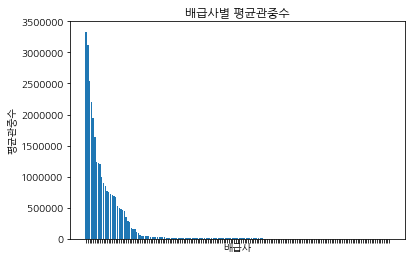

In [29]:
plt.bar(dist_mean.index, dist_mean)
plt.tick_params(top='off', bottom='on', left='on', right='off', labelleft='on', labelbottom='off')
plt.xlabel('배급사')
plt.ylabel('평균관중수')
plt.title('배급사별 평균관중수')
plt.show()

- 배급사별 평균관객수의 범위가 매우 크므로, 이를 로그화한 결과를 아래 그래프로 본다.
---

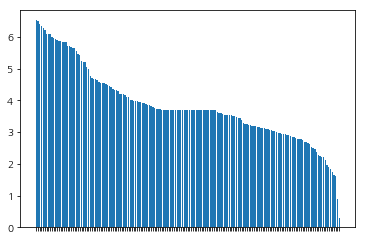

In [30]:
dist_mean_log10 = dist_mean.apply(lambda x : np.log10(x))

plt.bar(dist_mean_log10.index, dist_mean_log10)
plt.tick_params(top='off', bottom='on', left='on', right='off', labelleft='on', labelbottom='off')

In [31]:
dist_mean_log10.min(), dist_mean_log10.max(), dist_mean_log10.max()/dist_mean_log10.min()

(0.3010299956639812, 6.522829310448562, 21.668369944533836)

In [32]:
dist_mean_log10.head()

distributor
쇼박스         6.523
아이필름코퍼레이션   6.494
영구아트무비      6.405
CJCGV       6.344
NEW         6.288
Name: box_off_num, dtype: float64

- 이 배급사별 평균관객수를 6개(그래프를 보고 임의 선정)의 균일 구간으로 나눈다.

In [33]:
dist_mean_log10_6tiles = pd.cut(dist_mean_log10, 6)
dist_mean_log10_6tiles[:5]

distributor
쇼박스          (5.486, 6.523]
아이필름코퍼레이션    (5.486, 6.523]
영구아트무비       (5.486, 6.523]
CJCGV        (5.486, 6.523]
NEW          (5.486, 6.523]
Name: box_off_num, dtype: category
Categories (6, interval[float64]): [(0.295, 1.338] < (1.338, 2.375] < (2.375, 3.412] < (3.412, 4.449] < (4.449, 5.486] < (5.486, 6.523]]

In [34]:
dist_dict = dist_mean_log10_6tiles.cat.codes.astype(np.float32).to_dict() # 각 구간(caterogical)을 0~5까지의 정수로 변환해서 배급사명과 dict로.
print(dist_dict)

{'쇼박스': 5.0, '아이필름코퍼레이션': 5.0, '영구아트무비': 5.0, 'CJCGV': 5.0, 'NEW': 5.0, '이십세기폭스코리아': 5.0, '롯데엔터테인먼트': 5.0, '전망좋은영화사': 5.0, '주머니필름': 5.0, 'CGV아트하우스': 5.0, '시네마서비스': 5.0, '보람엔터테인먼트': 5.0, '스튜디오블루': 5.0, '씨네그루키다리이엔티': 5.0, '씨너스엔터테인먼트': 5.0, 'SK텔레콤': 5.0, 'JK필름': 5.0, '싸이더스': 5.0, '메가박스플러스엠': 5.0, 'OAL(올)': 5.0, '인벤트디': 5.0, '시너지': 5.0, '필라멘트픽쳐스': 5.0, '판씨네마': 5.0, '리틀빅픽쳐스': 4.0, 'KT': 4.0, '화앤담이엔티': 4.0, '프레인글로벌': 4.0, '스토리셋': 4.0, '마인스엔터테인먼트': 4.0, '이스트스카이필름': 4.0, '전주국제영화제': 4.0, '오퍼스픽쳐스': 4.0, '영화제작전원사': 4.0, '무비꼴라쥬': 4.0, 'THE픽쳐스': 4.0, '에이원엔터테인먼트': 4.0, '디씨드': 4.0, 'SBS콘텐츠허브': 4.0, '이달투': 4.0, '타임스토리': 4.0, '마운틴픽쳐스': 4.0, '백두대간': 3.0, '나이너스엔터테인먼트': 3.0, '팝파트너스': 3.0, '아우라픽처스': 3.0, '에스피엠': 3.0, '영화사조아': 3.0, '파이오니아21': 3.0, '엣나인필름': 3.0, 'BoXoo엔터테인먼트': 3.0, '스튜디오후크': 3.0, '스폰지': 3.0, '더피플': 3.0, '조이앤시네마': 3.0, '새인컴퍼니': 3.0, '영화사진진': 3.0, '시네마달': 3.0, '유비콘텐츠': 3.0, '예지림엔터테인먼트': 3.0, '스튜디오느림보': 3.0, '스톰픽쳐스코리아': 3.0, 'KBS미디어': 3.0, '스크린조이': 3.0, '영화사廊': 3.0, '와이드릴리즈': 3.0, '영화사조제': 3.0,

In [35]:
total['distributor_ord'] = total['distributor'].map(dist_dict)
total = total.rename(columns = {'distributor':'DROP_distributor'}) # 모든 처리가 끝난 후에 제거할 열 표시.
total.head().T

,0,1,2,3,4
box_off_num,23_398.000,7_072_501.000,6_959_083.000,217_866.000,483_387.000
dir_prev_bfnum,NaN,1_161_602.500,220_775.250,23_894.000,1.000
dir_prev_num,0,2,4,2,1
director,조병옥,우민호,장철수,구자홍,신근호
DROP_distributor,롯데엔터테인먼트,쇼박스,쇼박스,NEW,쇼박스
genre,액션,느와르,액션,코미디,코미디
num_actor,2,3,4,6,2
num_staff,91,387,343,20,251
release_time,2012-11-22,2015-11-19,2013-06-05,2012-07-12,2010-11-04
screening_rat,청소년 관람불가,청소년 관람불가,15세 관람가,전체 관람가,15세 관람가


- **∴** 배급사명이라는 문자열 정보를 러닝에 활용할 수 있는 숫자정보로 전환하기 위해, 배급사별 평균관중수를 이용하고자 했다.이때 test에만 존재하는 배급사는 train에서 구한 중간값으로 치환했다.
이후 배급사별 평균관중수를 그래프로 나타내보니, 그 범위가 너무 커서 이를 log한 후에, 이 값을 직접 이용할 수도 있지만,
여기선 이 값을 6개의 구간으로 나눠서 단순화 시켜보았다. 이때 이 숫자값(0,1..5)은 카테고리컬한 값이 아니라, Ordered number(평균관객수 정보를 담아) 값이므로
별도의 one-hot-encoding 같은 것을 하지 않는다.
---

## 3.3 genre

In [36]:
print(len(train.genre.unique()), len(test.genre.unique()))
print(len(list(set(test.genre) - set(train.genre))))
print(train.genre.unique())

12 12
0
['액션' '느와르' '코미디' '다큐멘터리' '뮤지컬' '드라마' '멜로/로맨스' '공포' '서스펜스' '애니메이션' '미스터리'
 'SF']


- train/test 모두 공통된 12개의 장르로 구성.

In [37]:
genre_mean = train.groupby('genre').agg({'box_off_num':'mean'}).sort_values('box_off_num', ascending=False)
genre_mean # 장르별 평균관객수

,box_off_num
genre,
느와르,2_263_695.111
액션,2_203_974.071
SF,1_788_345.692
코미디,1_193_914.000
드라마,625_689.792
공포,590_832.524
미스터리,527_548.176
멜로/로맨스,425_968.038
애니메이션,181_926.667


In [38]:
print("최소 {},\n\n최대 {},\n\n비율 {}".format(genre_mean.min(), genre_mean.max(), genre_mean.max()/genre_mean.min()))

최소 box_off_num   6_627.000
dtype: float64,

최대 box_off_num   2_263_695.111
dtype: float64,

비율 box_off_num   341.587
dtype: float64


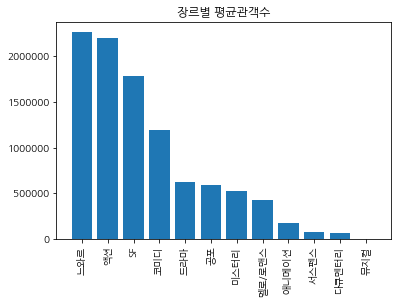

In [39]:
plt.bar(genre_mean.index, genre_mean.box_off_num)
plt.xticks(rotation=90)
plt.title('장르별 평균관객수')
plt.show()

In [40]:
genre_mean_log10 = np.log10(genre_mean) #log화.
print("최소 {},\n\n최대 {},\n\n비율 {}".format(genre_mean_log10.min(), genre_mean_log10.max(), genre_mean_log10.max()/genre_mean_log10.min()))

최소 box_off_num   3.821
dtype: float64,

최대 box_off_num   6.355
dtype: float64,

비율 box_off_num   1.663
dtype: float64


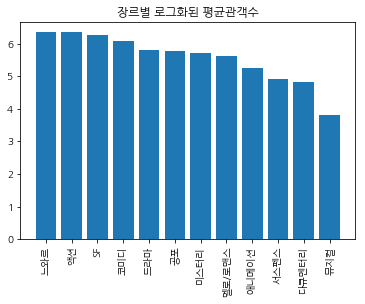

In [41]:
plt.bar(genre_mean_log10.index, genre_mean_log10.box_off_num)
plt.xticks(rotation=90)
plt.title('장르별 로그화된 평균관객수')
plt.show()

- '장르' 별로 관객수에 분명 차이를 보이고, 이는 실제 현실의 모습이기도 하므로, genre는 ordered number로 처리.단, 그 로그화한 이후엔 범위가 크지 않으므로 별도의 구간으로 나누는 것은 하지 않고, 바로 그 값을 이용해봤다.

In [42]:
genre_dict = genre_mean_log10.loc[:, 'box_off_num'].to_dict()
print(genre_dict)

{'느와르': 6.3548179329055205, '액션': 6.343206480968435, 'SF': 6.252451472933185, '코미디': 6.076973044824687, '드라마': 5.796359069509853, '공포': 5.771464394091215, '미스터리': 5.722262126187656, '멜로/로맨스': 5.629377014031057, '애니메이션': 5.259896362270532, '서스펜스': 4.917037879296558, '다큐멘터리': 4.827189947799599, '뮤지컬': 3.821316970591097}


In [43]:
total['genre_scaled'] = total['genre'].map(genre_dict)
total = total.rename(columns = {'genre':'DROP_genre'}) # 모든 처리가 끝난 후에 제거할 열 표시.
total.head().T

,0,1,2,3,4
box_off_num,23_398.000,7_072_501.000,6_959_083.000,217_866.000,483_387.000
dir_prev_bfnum,NaN,1_161_602.500,220_775.250,23_894.000,1.000
dir_prev_num,0,2,4,2,1
director,조병옥,우민호,장철수,구자홍,신근호
DROP_distributor,롯데엔터테인먼트,쇼박스,쇼박스,NEW,쇼박스
DROP_genre,액션,느와르,액션,코미디,코미디
num_actor,2,3,4,6,2
num_staff,91,387,343,20,251
release_time,2012-11-22,2015-11-19,2013-06-05,2012-07-12,2010-11-04
screening_rat,청소년 관람불가,청소년 관람불가,15세 관람가,전체 관람가,15세 관람가


## 3.4 release_time

In [44]:
train.release_time.describe()

count            600
unique           330
top       2015-10-22
freq               6
Name: release_time, dtype: object

In [45]:
test.release_time.describe()

count            243
unique           182
top       2012-11-22
freq               4
Name: release_time, dtype: object

- 'release_time'은 train/test 모두 결측치가 없음.
---

- 개봉날짜(년-월-일)는 개봉한 **달(月)** 혹은 **분기별** 정도가 관객수와 관련있을거라고 상식적으로 판단.

In [46]:
total['release_month'] = total.release_time.map(lambda x: x.split('-')[1]) #년-월-일 ==> 월로 변환.
total[['release_time', 'release_month']].head()

,release_time,release_month
0,2012-11-22,11
1,2015-11-19,11
2,2013-06-05,06
3,2012-07-12,07
4,2010-11-04,11


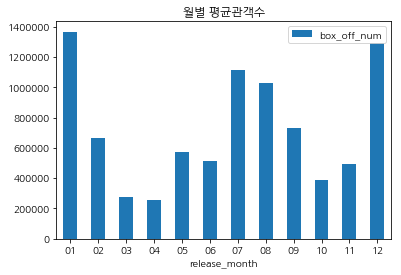

In [47]:
# train 데이터셋에서 월별 평균관객수를 그려본다.
month_boxoff = total[~total.box_off_num.isna()].groupby('release_month').agg({'box_off_num':'mean'})
month_boxoff.plot(kind='bar', title='월별 평균관객수')
plt.xticks(rotation=0)
plt.show()

- 분기별(즉 연속된 3개월)로 묶을 경우에, "1,2,3 / 4,5,6 / 7,8,9 / 10,11,12"로의 구분은, 각 분기 내에서 값의 편차가 심해서 고려치 않기로.

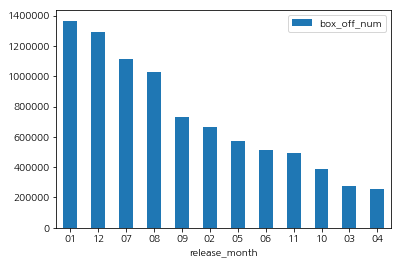

In [48]:
month_boxoff.sort_values('box_off_num', ascending=False).plot.bar()
plt.xticks(rotation=0)
plt.show()

- **일단은 가장 큰 값(1월의 평균관객수)을 기준으로 ordered number로 변환.**
- 훈련 결과 오버피팅이 심할 경우 등에서, 비슷한 수준의 월별(1월, 12월 7월, 8월을 하나의 카테고리로 하는 식)로 묶는 카테고리화 작업을 진행 가능.

In [49]:
month_boxoff.sort_values('box_off_num', inplace=True)
month_boxoff

,box_off_num
release_month,
04,258_166.702
03,273_887.365
10,385_904.150
11,495_653.889
06,512_286.483
05,575_685.246
02,663_025.194
09,731_528.633
08,1_029_161.673


In [50]:
i = 0
for index, row in month_boxoff.iterrows():
    row.box_off_num = i
    i += 1

month_boxoff

,box_off_num
release_month,
04,0.000
03,1.000
10,2.000
11,3.000
06,4.000
05,5.000
02,6.000
09,7.000
08,8.000


In [51]:
month_boxoff_dict = month_boxoff.loc[:, 'box_off_num'].to_dict()
month_boxoff_dict

{'04': 0.0,
 '03': 1.0,
 '10': 2.0,
 '11': 3.0,
 '06': 4.0,
 '05': 5.0,
 '02': 6.0,
 '09': 7.0,
 '08': 8.0,
 '07': 9.0,
 '12': 10.0,
 '01': 11.0}

- 4월부터 1월까지 비교적 균일하게 커가는 그래프 모습에 비춰서, 이번엔 0~11까지의 순차적 값으로 치환해봄. 가장 큰 1월의 값에 대한 실수적인 스케일 값으로 변환할 수도 있는데, 다양한 시도를 해본다는 측면에서 여기서는 0, 1,.. 식으로 시도. 물론 향후 결과가 좋지 못할 경우엔 바꿔 볼 여지는 있음.

In [52]:
total['release_month_ord'] = total['release_month'].map(month_boxoff_dict)
total = total.rename(columns = {'release_time':'DROP_release_time', 'release_month':'DROP_release_month'}) # 모든 처리가 끝난 후에 제거할 열 표시.
total.sort_index(axis=1, inplace=True) # 단순히 "DROP_"으로 시작하는 컬럼을 먼저 나타내기 위한 처리.
total.head().T

,0,1,2,3,4
DROP_distributor,롯데엔터테인먼트,쇼박스,쇼박스,NEW,쇼박스
DROP_genre,액션,느와르,액션,코미디,코미디
DROP_release_month,11,11,06,07,11
DROP_release_time,2012-11-22,2015-11-19,2013-06-05,2012-07-12,2010-11-04
DROP_title,개들의 전쟁,내부자들,은밀하게 위대하게,나는 공무원이다,불량남녀
DROP_title_length,5,4,8,7,4
box_off_num,23_398.000,7_072_501.000,6_959_083.000,217_866.000,483_387.000
dir_prev_bfnum,NaN,1_161_602.500,220_775.250,23_894.000,1.000
dir_prev_num,0,2,4,2,1
director,조병옥,우민호,장철수,구자홍,신근호


**∴** release_time(년-월-일)에서 월 정보만 포착해서 feature화. 단순화 시키기 위해, 분기별로 월을 다시 묶어볼 수 있지만, 같은 분기별 평균관객수의 편차가 심해서 이는 시도하지 않고, 대신 값들이 비교적 균일하게 변한다는 사실에 주안을 두고, 이번에는 releast_time을 0에서 11(평균관객수가 최대)까지의 ordered number를 할당하는 것으로.

## 3.5 time

- 상영시간(분)에 따른 관객수의 분포를 그려본다.

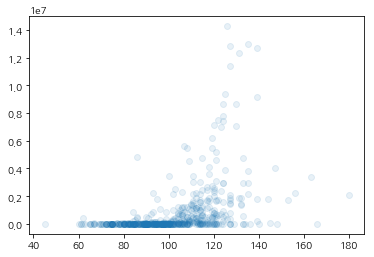

In [53]:
plt.scatter(train.time, train.box_off_num, alpha=0.1)

- 영화 상영시간을 그래프를 참조해, 구간내 편차가 크지 않은 구간으로 나누고, 그 구간내의 평균관객수를 한번 살펴본다.

In [54]:
train.time.mean(), train.time.median() # 두 값의 차이가 크지 않다.

(100.86333333333333, 100.0)

In [55]:
train[train.time<80]['box_off_num'].mean()

13394.727272727272

In [56]:
train[(train.time>=80) & (train.time<100)]['box_off_num'].mean()

81805.24568965517

In [57]:
train[(train.time>=100) & (train.time<120)]['box_off_num'].mean()

707471.9425837321

In [58]:
train[(train.time>=120) & (train.time<140)]['box_off_num'].mean()

2913704.4457831327

In [59]:
train[(train.time>=140)]['box_off_num'].mean()

1534707.7

- 상영시간 기준으로 (80분 이하), (80~100분), (100~120분), (120~140분), (140분 이상)의 5구간으로 나눠 생각해보기로 일단 결정. 각 구산별 평균값이 적게는 2배에서 10배이상 차이가 남.

---
- 이제 이 구간을 기준으로 이 **상영사간(time)을 feature로 바꾸는 방법을 강구**해야 한다.
- 지금까지의 방법 중 하나로 본다면, 구간내에서의 평균 관객수 값으로 일괄 치환하는 방법 등이 있겠지만, (순전히) 다양한 시도를 해본다는 의미도 넣어서 이번에는 구간내의 (통상)trend라고 하는 개념을 이용해 보고자 한다.
- 즉 각 구간내의 time 값에 대해 상수값(구간내 평균)으로 치환하는 앞선 방법들 대신에, 구간 내의 데이터에 linear regression(러닝적인 개념이라기보단, 산술적인 보간 개념?)을 적용해서 구간 내 데이터를 가장 잘 설명하는 직선을 구하고, 그 직선 상의 값으로 치환하는 방법을 사용해본다. 물론 이 방법은 구간 내 평균값으로 치환하는 것에 비해, 방법론적으로 쓸데없이(?) 조금 복잡한 방법인데 반해, 이 방법 적용시 더 좋은 결과를 낸다는 보장은 없다.
- 다만 실제 값들의 분포에 비춰 예상해 볼 수 있는 것은, 실제값(상영시간 기준 평균관객수)이 시간별로 편차가 가장 큰 분포(실제 데이터분포)를 가지고, 구간내에 평균값으로 일괄 치환한 경우에 가장 그 분포의 편차가 적게 되는 반면 너무 simplify된 경향이 있으며, 이 구간내 직선값으로 치환하는 방법은 그 중간 정도의 편차와 복잡도를 가지게 변환하는 방법이라는 것을 알 수 있다.

---

### 3.5.1 time < 80

In [60]:
from sklearn.linear_model import LinearRegression

def calc_time_trend(df):
    lr = LinearRegression()
    lr.fit(df.time.values.reshape(-1, 1), df.box_off_num.values.reshape(-1, 1)) # 1차원 데이터를 2차원 형태로 reshape.
    y = lr.predict(df.time.values.reshape(-1, 1))
    df['trend'] = y # 해당 보간된 점들을 임시로 그래프로 그려보기 위한 목적.

    return lr.coef_[0][0], lr.intercept_[0] # 구간 내 데이터를 가장 잘 설명하는 직선의 기울기/절편을 반환.

- (참고로 train 데이터셋을 이용할 때, total에서 간적적으로 혹은 train을 직접 이용하는 경우가 각각 있는데, train 데이터에 해당 컬럼이 정상적이고 누락데이터가 없다면 train에서 직접 적용하고, 그렇지 않다면 total에서 컬럼을 가공한 후에 total에서 train을 (불리안 조건으로) 뽑아서 적용하고 있다.)

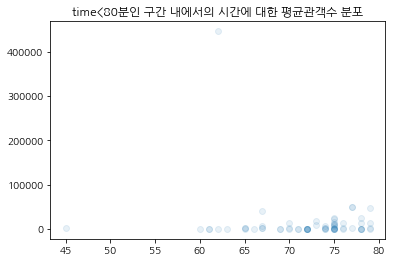

In [61]:
tmp = train[train.time<80][['time', 'box_off_num']]
plt.scatter(tmp.time, tmp.box_off_num, alpha=0.1)
plt.title('time<80분인 구간 내에서의 시간에 대한 평균관객수 분포')
plt.show()

- 그래프 상에서 상단에 outlier가 한점 발견됨. 이 데이터들의 보간(보간이라고 가칭함. 즉 구간내에서 "새로운 시간값에 대한 관객수 예측"을 할 목적이 아니라, 기존데이터를 잘 설명하는 직선을 찾는 개념이기에) 적용시에는 이 점 제거한 후 계산.

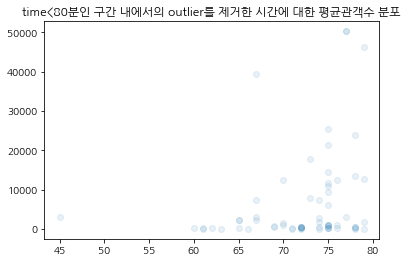

In [62]:
rm_idx = tmp[tmp.box_off_num == tmp.box_off_num.max()].index.values[0] # 위 그래프 상에서 최대값을 가진 한 점의 index.
tmp.drop(rm_idx, axis=0, inplace=True) # outlier제거.
plt.scatter(tmp.time, tmp.box_off_num, alpha=0.1)
plt.title('time<80분인 구간 내에서의 outlier를 제거한 시간에 대한 평균관객수 분포')
plt.show()

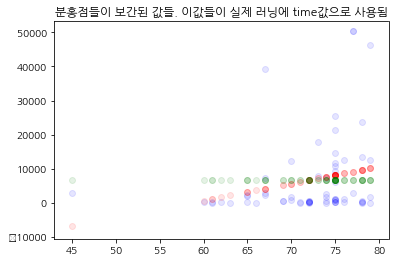

In [63]:
trend_factors = []
trend_factors.append(calc_time_trend(tmp)) # 구간에 대한 직선의 기울기/절편을 리스트에 저장.

tmp['box_off_num_mean'] = tmp.box_off_num.mean() # 그냥 구간내 평균값을 그래프에 한번 표시해보기 위해.

plt.scatter(tmp.time, tmp.box_off_num, alpha=0.1, color='b')
plt.scatter(tmp.time, tmp.trend, alpha=0.1, color='r')
plt.scatter(tmp.time, tmp.box_off_num_mean, alpha=0.1, color='g')
plt.title('분홍점들이 보간된 값들. 이값들이 실제 러닝에 time값으로 사용됨')
plt.show()

- 위 그래프에서 보다시피, 실제 time 데이터(blue)의 분포가 넓고, 평균값(green)으로 치환한 경우에 비해, 리그레션한 값(red)으로 치환한 경우의 데이터 분포가 중간정도 됨.
---

- 이제 남은 과정은 각시간 구간마다 위 과정을 반복해, trend_factors 리스트에 순차적으로 각 구간내에서의 직선의 기울기/절편을 저장한 후,
- 전체 time 데이터를 구간별 직선 상의 값으로 (기울기/절편을 이용해) 치환 할것임.

### 3.5.2 80<=time<100

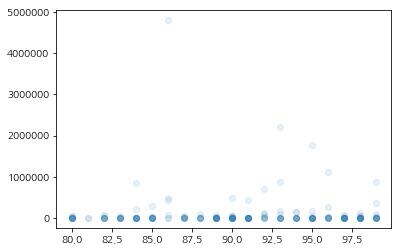

In [64]:
tmp = train[(train.time>=80) & (train.time<100)][['time', 'box_off_num']]
plt.scatter(tmp.time, tmp.box_off_num, alpha=0.1)
plt.show()

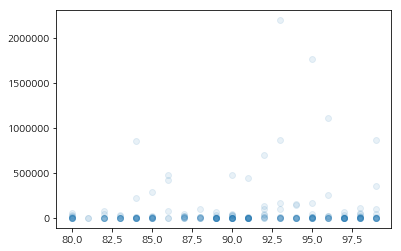

In [65]:
rm_idx = tmp[tmp.box_off_num == tmp.box_off_num.max()].index.values[0] # 위 그래프 상에서 최대값을 가진 한 점의 index.
tmp.drop(rm_idx, axis=0, inplace=True) # outlier제거.

plt.scatter(tmp.time, tmp.box_off_num, alpha=0.1) # outlier 제거 후 그래프.
plt.show()

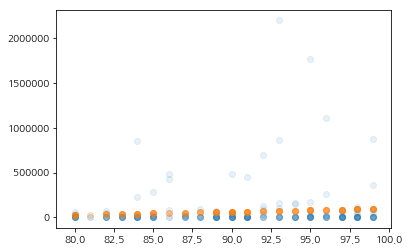

In [66]:
trend_factors.append(calc_time_trend(tmp))

plt.scatter(tmp.time, tmp.box_off_num, alpha=0.1)
plt.scatter(tmp.time, tmp.trend, alpha=0.1)
plt.show() # 이후 구간내 평균값은 나타내지 않음.

In [67]:
trend_factors

[(501.585328718795, -29406.579687982085),
 (3423.242426864853, -248306.70560257506)]

### 3.5.3 100<=time<120

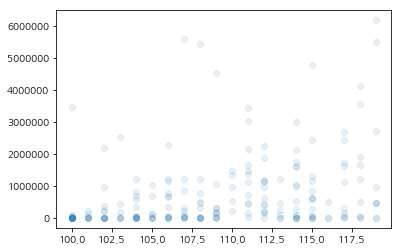

In [68]:
tmp = train[(train.time>=100) & (train.time<120)][['time', 'box_off_num']]
plt.scatter(tmp.time, tmp.box_off_num, alpha=0.1)
plt.show()

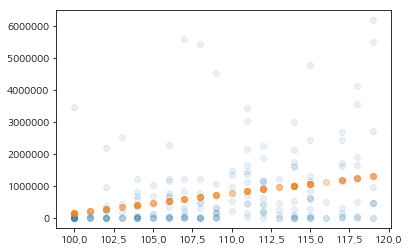

In [69]:
trend_factors.append(calc_time_trend(tmp))

plt.scatter(tmp.time, tmp.box_off_num, alpha=0.1)
plt.scatter(tmp.time, tmp.trend, alpha=0.1)
plt.show()

### 3.5.4 120<=time<140

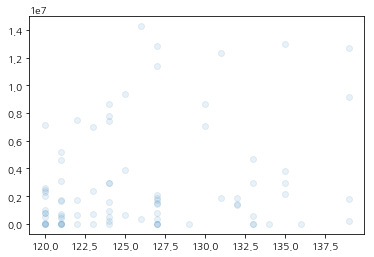

In [70]:
tmp = train[(train.time>=120) & (train.time<140)][['time', 'box_off_num']]
plt.scatter(tmp.time, tmp.box_off_num, alpha=0.1)
plt.show()

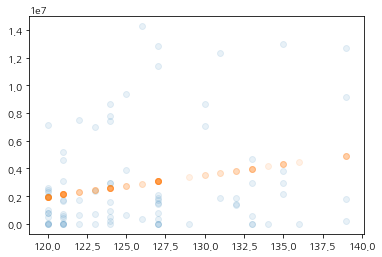

In [71]:
trend_factors.append(calc_time_trend(tmp))

plt.scatter(tmp.time, tmp.box_off_num, alpha=0.1)
plt.scatter(tmp.time, tmp.trend, alpha=0.1)
plt.show()

### 3.5.5 time>=140

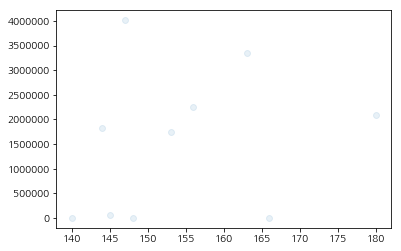

In [72]:
tmp = train[(train.time>=140)][['time', 'box_off_num']]
plt.scatter(tmp.time, tmp.box_off_num, alpha=0.1)
plt.show()

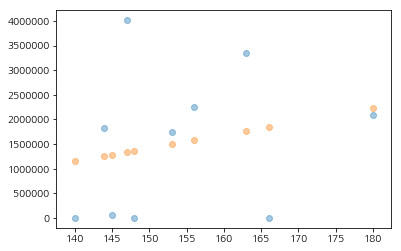

In [73]:
trend_factors.append(calc_time_trend(tmp))

plt.scatter(tmp.time, tmp.box_off_num, alpha=0.4)
plt.scatter(tmp.time, tmp.trend, alpha=0.4)
plt.show()

In [74]:
trend_factors # 구간별로 구한 직선의 기울기/절편.

[(501.585328718795, -29406.579687982085),
 (3423.242426864853, -248306.70560257506),
 (61388.37147294578, -5985329.169294462),
 (155626.9153972123, -16700911.96349684),
 (27187.667154138624, -2657630.5751681756)]

### 3.5.6 test세트의 time 확인

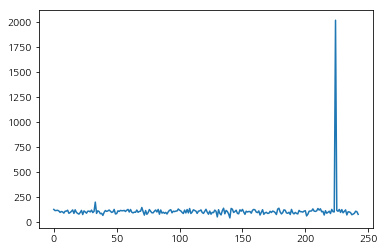

In [75]:
plt.plot(test.time)

- 이상값이 보임.

In [76]:
test[test.time == test.time.max()]

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
224,슈퍼레이서 엔지,(주)에이원 엔터테인먼트,애니메이션,2015-09-10,2015,전체 관람가,허선,nan,0,4,5


- test세트의 224번째 데이터에서 **time 정보가 2015분**으로 잘못 되어 있음을 알 수 있다.
- 영화포털의 DB를 찾아보면 63분으로 나온다.
- 하지만, 일반적으로는 원래의 정보를 알 수 없는 경우가 보통이므로, 영화DB값이 아닌 **주어진 다른 데이터를 이용해 추론**해서 정하도록 한다. 특히 train 데이터가 아닌 test 데이터상의 결측치이므로 더.
- **이 영화와 'genre'가 같은 영화들의 평균 time으로 정하는게 가장 합리적이지 않나 판단.**

In [77]:
tmp = train.groupby('genre').agg({'time':'mean'})
tmp # 장르별 평균 상영시간.

,time
genre,
SF,101.385
공포,100.214
느와르,115.370
다큐멘터리,88.054
드라마,104.652
멜로/로맨스,96.641
뮤지컬,107.000
미스터리,102.588
서스펜스,112.000


In [78]:
anim_mean_time = tmp.loc['애니메이션']
anim_mean_time 

time   82.571
Name: 애니메이션, dtype: float64

In [79]:
total[total.DROP_title=='슈퍼레이서 엔지'] # 이런 경우를 대비해, 'title'열을 앞서 바로 drop하지 않고, 여기서 이용함.

,DROP_distributor,DROP_genre,DROP_release_month,DROP_release_time,DROP_title,DROP_title_length,box_off_num,dir_prev_bfnum,dir_prev_num,director,...,genre_scaled,num_actor,num_staff,release_month_ord,screening_rat,time,"title_(0, 1]","title_(1, 5]","title_(5, 9]","title_(9, 23]"
824,에이원엔터테인먼트,애니메이션,09,2015-09-10,슈퍼레이서 엔지,7,nan,nan,0,허선,...,5.260,5,4,7.000,전체 관람가,2015,0,0,1,0


In [80]:
total.loc[824, 'time'] = int(anim_mean_time)
total[total.DROP_title=='슈퍼레이서 엔지'].time.values[0]

82

- test 데이터셋의 time 이상치를, 해당 영화와 같은 장르의 평균 시간으로 치환 완료.
---

### 3.5.7 전체 데이터셋의 'time' 컬럼의 값을, 구간별로 리그레션한 직선형태의 값으로 변환.

In [81]:
def time_to_trend(x):
    """
    time 데이터(x)를 입력 받아서, 그 time이 속하는 구간을 찾고, 해당 구간에 맞는 직선의 기울기/절편을 이용해 직선상의 평균관객수 값을 반환. 
    """
    
    if x < 80:
        i = 0  # time이 속하는 구간에 대한 리스트 인덱스 i.
    elif (80<=x) & (x<100):
        i = 1
    elif (100<=x) & (x<120):
        i = 2
    elif (120<=x) & (x<140):
        i = 3
    elif (140<=x):
        i = 4
        
    return x*trend_factors[i][0] + trend_factors[i][1]

total['time_trend'] = total['time'].map(time_to_trend)
time_trend_max = total['time_trend'].max()
total['time_trend'] = total['time_trend'] / time_trend_max # 최대 값으로 스케일링.(0.0~1.0)

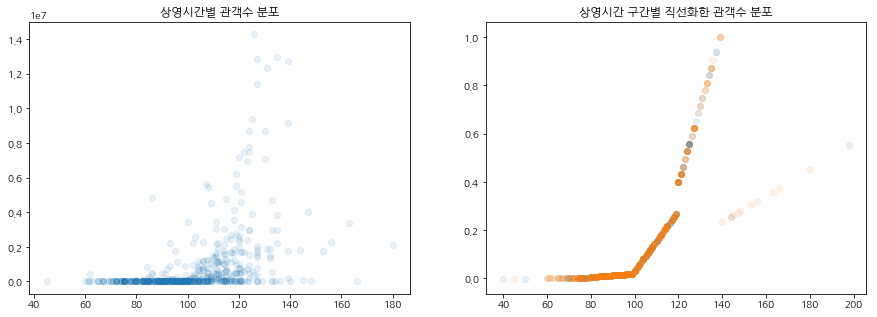

In [82]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.scatter(total[~total.box_off_num.isna()].time, total[~total.box_off_num.isna()].box_off_num, alpha=0.1)
plt.title('상영시간별 관객수 분포')

plt.subplot(1,2,2)
plt.scatter(total[total.box_off_num.isna()].time, total[total.box_off_num.isna()].time_trend, alpha=0.1)
plt.scatter(total[~total.box_off_num.isna()].time, total[~total.box_off_num.isna()].time_trend, alpha=0.1)
plt.title('상영시간 구간별 직선화한 관객수 분포')

plt.show()

In [83]:
total = total.rename(columns = {'time':'DROP_time'}) # 모든 처리가 끝난 후에 제거할 열 표시.
total.sort_index(axis=1, inplace=True)
total.head().T

,0,1,2,3,4
DROP_distributor,롯데엔터테인먼트,쇼박스,쇼박스,NEW,쇼박스
DROP_genre,액션,느와르,액션,코미디,코미디
DROP_release_month,11,11,06,07,11
DROP_release_time,2012-11-22,2015-11-19,2013-06-05,2012-07-12,2010-11-04
DROP_time,96,130,123,101,108
DROP_title,개들의 전쟁,내부자들,은밀하게 위대하게,나는 공무원이다,불량남녀
DROP_title_length,5,4,8,7,4
box_off_num,23_398.000,7_072_501.000,6_959_083.000,217_866.000,483_387.000
dir_prev_bfnum,NaN,1_161_602.500,220_775.250,23_894.000,1.000
dir_prev_num,0,2,4,2,1


**∴** 상영시간 컬럼은 그 값의 분포가 커서, 이를 어떻게 러닝을 위한 숫자로 feature화 하느냐는 문제에서, 이번에는 원 데이터의 분포 그래프를 바탕으로 적당한 시간 구간을 정한 다음에, 이 구간에서는 직선적인 변화를 한다는 가정하에, 각 구간별로 linear regression을 통해 직선의 기울기/절편을 구한 다음, 전체 time을 위 직선상의 값으로 치환. 이후 최대값을 기준으로 스케일링한 time_trend feature로 이용.

## 3.6 screening_rat

In [84]:
train.screening_rat.describe() # 등급은 총 4종류.

count          600
unique           4
top       청소년 관람불가
freq           204
Name: screening_rat, dtype: object

In [85]:
train.screening_rat.isna().sum(), test.screening_rat.isna().sum() # 결측치 없음.

(0, 0)

In [86]:
train.screening_rat.unique()

array(['청소년 관람불가', '15세 관람가', '전체 관람가', '12세 관람가'], dtype=object)

In [87]:
tmp = train.groupby('screening_rat').agg({'box_off_num':'mean'}).sort_values('box_off_num', ascending=False)
tmp

,box_off_num
screening_rat,
15세 관람가,1_247_518.644
12세 관람가,844_980.902
청소년 관람불가,364_181.328
전체 관람가,135_100.457


In [88]:
tmp = tmp / tmp.max()
tmp

,box_off_num
screening_rat,
15세 관람가,1.000
12세 관람가,0.677
청소년 관람불가,0.292
전체 관람가,0.108


- 관람등급을 위 평균관객수 비율로 단순 치환한다.

In [89]:
screening_rat_dict = tmp.loc[:, 'box_off_num'].to_dict()
screening_rat_dict

{'15세 관람가': 1.0,
 '12세 관람가': 0.6773292778587592,
 '청소년 관람불가': 0.29192455784937155,
 '전체 관람가': 0.10829534068984807}

In [90]:
total['screening_rat_scaled'] = total['screening_rat'].map(screening_rat_dict)
total = total.rename(columns = {'screening_rat':'DROP_screening_rat'}) # 모든 처리가 끝난 후에 제거할 열 표시.
total.sort_index(axis=1, inplace=True) # DROP_ 칼럼을 앞으로 모으기 위한 조치.
total.head().T

,0,1,2,3,4
DROP_distributor,롯데엔터테인먼트,쇼박스,쇼박스,NEW,쇼박스
DROP_genre,액션,느와르,액션,코미디,코미디
DROP_release_month,11,11,06,07,11
DROP_release_time,2012-11-22,2015-11-19,2013-06-05,2012-07-12,2010-11-04
DROP_screening_rat,청소년 관람불가,청소년 관람불가,15세 관람가,전체 관람가,15세 관람가
DROP_time,96,130,123,101,108
DROP_title,개들의 전쟁,내부자들,은밀하게 위대하게,나는 공무원이다,불량남녀
DROP_title_length,5,4,8,7,4
box_off_num,23_398.000,7_072_501.000,6_959_083.000,217_866.000,483_387.000
dir_prev_bfnum,NaN,1_161_602.500,220_775.250,23_894.000,1.000


**∴** 관람등급은 총4종류에 결측치가 없어서, 단순히 등급별 평균 관객수를 기준으로 0~1.0 사이의 값으로 스케일링 했다.

## 3.7 director

In [91]:
train.director.describe()

count     600
unique    472
top       홍상수
freq        7
Name: director, dtype: object

In [92]:
test.director.describe()

count     243
unique    220
top       이정호
freq        3
Name: director, dtype: object

In [93]:
s1 = set(train.director.values)
s2 = set(test.director.values)
print("test 데이터셋에만 존재하는 감독 수", len(list(set(s2) - set(s1))))

test 데이터셋에만 존재하는 감독 수 142


In [94]:
print("전체 데이터셋에만 존재하는 감독 수", len(list(set(s2) | set(s1))))

전체 데이터셋에만 존재하는 감독 수 614


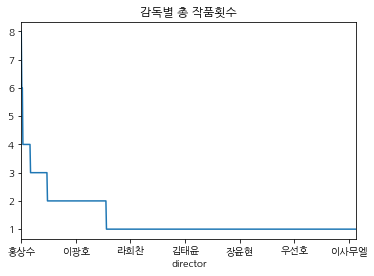

In [95]:
director_count = total.groupby('director').agg({'director':'count'}).director.sort_values(ascending=False)
director_count.plot(title='감독별 총 작품횟수')
plt.show()

In [96]:
director_count.head(20)

director
홍상수    8
전규환    6
조성규    6
이상우    4
윤여창    4
장진     4
곽경택    4
이준익    4
장률     4
오멸     4
노진수    4
민규동    4
김성훈    4
김봉은    4
우민호    4
신연식    4
신재호    4
김진영    3
임순례    3
이숭환    3
Name: director, dtype: int64

- 한 감독이 6번, 8번 참여한 경우가 매우 적으므로, 4번 이상은 모두 4로 취급.
- 따라서 감독이름 --> 1, 2, 3, 4의 카테고리 번호로 할당. 많이 참여한 횟수와 관객수의 관계가 약하다고 판단해서, 단순히 구분(categorical)하는 의미로만 사용.
- 최종적으로 one hot encoding 적용하기 위해, 숫자가 아닌 문자열로 저장(**cat을 더해서**). 이는 panda의 get_dummies() 메소드가 숫자가 아닌 부분을 일괄 적용하기 때문에.

In [97]:
director_count2 = director_count.map(lambda x: 'cat' + str(min(x, 4))) # for catergorical.
director_dict2 = director_count2.to_dict()
print(director_dict2) # 감독별 작품수를 최대 4로 해서 매핑.

{'홍상수': 'cat4', '전규환': 'cat4', '조성규': 'cat4', '이상우': 'cat4', '윤여창': 'cat4', '장진': 'cat4', '곽경택': 'cat4', '이준익': 'cat4', '장률': 'cat4', '오멸': 'cat4', '노진수': 'cat4', '민규동': 'cat4', '김성훈': 'cat4', '김봉은': 'cat4', '우민호': 'cat4', '신연식': 'cat4', '신재호': 'cat4', '김진영': 'cat3', '임순례': 'cat3', '이숭환': 'cat3', '박훈정': 'cat3', '김기덕': 'cat3', '권칠인': 'cat3', '김태균': 'cat3', '박철수': 'cat3', '김진만': 'cat3', '장건재': 'cat3', '김조광수': 'cat3', '김정훈': 'cat3', '조조 히데오': 'cat3', '전수일': 'cat3', '전화성': 'cat3', '정성복': 'cat3', '김상진': 'cat3', '김상철': 'cat3', '김현석': 'cat3', '임상수': 'cat3', '이정호': 'cat3', '이수성': 'cat3', '이전': 'cat3', '이석훈': 'cat3', '이송희일': 'cat3', '신수원': 'cat3', '강우석': 'cat3', '남기웅': 'cat3', '손석': 'cat3', '구혜선': 'cat3', '류승완': 'cat3', '정용기': 'cat2', '이재한': 'cat2', '김정환': 'cat2', '이성규': 'cat2', '김정욱': 'cat2', '노덕': 'cat2', '장철수': 'cat2', '장훈': 'cat2', '전계수': 'cat2', '이정범': 'cat2', '김일종': 'cat2', '윤종빈': 'cat2', '전재홍': 'cat2', '김성수': 'cat2', '박배일': 'cat2', '이재용': 'cat2', '정기훈': 'cat2', '김영탁': 'cat2', '문승욱': 'cat

In [98]:
total['director_category'] = total['director'].map(director_dict2)
total = total.rename(columns = {'director':'DROP_director'}) # 모든 처리가 끝난 후에 제거할 열 표시.
total.sort_index(axis=1, inplace=True)
total.head().T

,0,1,2,3,4
DROP_director,조병옥,우민호,장철수,구자홍,신근호
DROP_distributor,롯데엔터테인먼트,쇼박스,쇼박스,NEW,쇼박스
DROP_genre,액션,느와르,액션,코미디,코미디
DROP_release_month,11,11,06,07,11
DROP_release_time,2012-11-22,2015-11-19,2013-06-05,2012-07-12,2010-11-04
DROP_screening_rat,청소년 관람불가,청소년 관람불가,15세 관람가,전체 관람가,15세 관람가
DROP_time,96,130,123,101,108
DROP_title,개들의 전쟁,내부자들,은밀하게 위대하게,나는 공무원이다,불량남녀
DROP_title_length,5,4,8,7,4
box_off_num,23_398.000,7_072_501.000,6_959_083.000,217_866.000,483_387.000


**∴** 감독이름(director)을 감독의 작품수(director_category)로 매핑해서 cat1, cat2 식의 문자열 feature 생성. 마지막에 pandas의 get_dummies() 적용하면 이 문자열들만 변환됨.

## 3.8 dir_prev_bfnum

In [99]:
total['dir_prev_bfnum'].head(10)

0             nan
1   1_161_602.500
2     220_775.250
3      23_894.000
4           1.000
5     837_969.000
6             nan
7     739_522.000
8             nan
9             nan
Name: dir_prev_bfnum, dtype: float64

In [100]:
print("전체갯수={}, 결측치 갯수={}".format(len(total['dir_prev_bfnum']), total['dir_prev_bfnum'].isna().sum()))

전체갯수=843, 결측치 갯수=466


- 전체 데이터를 기준으로도 결측치가 과반수를 넘음.
---

In [101]:
tmp = train[train.dir_prev_num != 0][['box_off_num', 'dir_prev_bfnum']] # dir_prev_bfnum가 NaN(결측)인 경우엔 dir_prev_num가 0이므로, 후자를 조건으로 이용.
print(tmp.corr())

                box_off_num  dir_prev_bfnum
box_off_num           1.000           0.283
dir_prev_bfnum        0.283           1.000


- dir_prev_bfnum 데이터가 있는 경우에 --> box_off_num과의 correlation도 비교적 낮다
---

In [102]:
train0 = train[train.dir_prev_num == 0] # dir_prev_bfnum가 NaN(결측)인 경우엔 dir_prev_num가 0이므로, 후자를 조건으로 이용.
train1 = train[train.dir_prev_num != 0]

print("dir_prev_bfnum가 결측인 데이터의 평균관객수={:_.0f}, 존재하는 경우의 평균관객수={:_.0f}".format(train0.box_off_num.mean(), train1.box_off_num.mean()))

dir_prev_bfnum가 결측인 데이터의 평균관객수=349_204, 존재하는 경우의 평균관객수=1_146_932


- 이 dir_prev_bfnum가 데이터의 유무로 나눈 두 세트 간의 평균 관객수가 많이 차이남
---

- dir_prev_bfnum은 꽤 데이터 손실이 큰 항목
- 이 값이 있는 데이터만 --> box_off_num과의 correlation도 낮다.
- 이 데이터의 유무로 나눈 두 세트 간의 평균 관객수가 많이 차이남.
- **그렇다고 다른 항목으로 감독의 과거평균 관객수를 유추하는 것도 합리적이지 않다 판다.**
- 따라서 이 데이터를 유무에 따른 평균관객수의 차이가 큼에 착안해서, 단순히 **이 데이터의 유무만으로 구분**하도록 feature 결정.

In [103]:
# 두가지 경우의 catergorical로 바꿀것이므로, 실제 true/false는 의미가 없어서 ~하지 않았음.
# astype(str) 함으로서, 불리안 True를 문자열 "True"로 바꿔서 치환. <-- pd.get_dummies() 적용시, 문자열만 적용되는 관계로 이의 적용을 받게 하기 위함.
total['dir_prev_bfnum_category'] = total.dir_prev_bfnum.isna().astype(str) 

total = total.rename(columns = {'dir_prev_bfnum':'DROP_dir_prev_bfnum'}) # 모든 처리가 끝난 후에 제거할 열 표시.
total.sort_index(axis=1, inplace=True)
total.head().T

,0,1,2,3,4
DROP_dir_prev_bfnum,NaN,1_161_602.500,220_775.250,23_894.000,1.000
DROP_director,조병옥,우민호,장철수,구자홍,신근호
DROP_distributor,롯데엔터테인먼트,쇼박스,쇼박스,NEW,쇼박스
DROP_genre,액션,느와르,액션,코미디,코미디
DROP_release_month,11,11,06,07,11
DROP_release_time,2012-11-22,2015-11-19,2013-06-05,2012-07-12,2010-11-04
DROP_screening_rat,청소년 관람불가,청소년 관람불가,15세 관람가,전체 관람가,15세 관람가
DROP_time,96,130,123,101,108
DROP_title,개들의 전쟁,내부자들,은밀하게 위대하게,나는 공무원이다,불량남녀
DROP_title_length,5,4,8,7,4


**∴** dir_prev_bfnum 컬럼은 결측치가 과반수이고, 또 다른 데이터로 이를 유추 보강할 성격의 데이터가 아니며, 그 결측유무에 따란 평균관객수의 크기 차이가 큰 점에 착안해서, 단순히 데이터의 NaN 유무만을 나타내는 0/1 관계의 Categorical data로 feature 결정.

## 3.9 dir_prev_num

In [104]:
total.dir_prev_num.unique()

array([0, 2, 4, 1, 3, 5, 6])

- 데이터의 성격상 그 값 그대로 featue 사용

In [105]:
total['dir_prev_num'] = total.dir_prev_num.map(lambda x: 'cat'+str(x)) # 숫자가 아니라, 문자열이 되게 하기 위한 조치.

In [106]:
total = total.rename(columns = {'dir_prev_num':'dir_prev_num_category'}) # 모든 처리가 끝난 후에 제거할 열 표시.
total.sort_index(axis=1, inplace=True)
total.head().T

,0,1,2,3,4
DROP_dir_prev_bfnum,NaN,1_161_602.500,220_775.250,23_894.000,1.000
DROP_director,조병옥,우민호,장철수,구자홍,신근호
DROP_distributor,롯데엔터테인먼트,쇼박스,쇼박스,NEW,쇼박스
DROP_genre,액션,느와르,액션,코미디,코미디
DROP_release_month,11,11,06,07,11
DROP_release_time,2012-11-22,2015-11-19,2013-06-05,2012-07-12,2010-11-04
DROP_screening_rat,청소년 관람불가,청소년 관람불가,15세 관람가,전체 관람가,15세 관람가
DROP_time,96,130,123,101,108
DROP_title,개들의 전쟁,내부자들,은밀하게 위대하게,나는 공무원이다,불량남녀
DROP_title_length,5,4,8,7,4


**∴** 감독의 전작 참여수는 그 데이터 성격상 그대로 이용하면서 Categorical data로만 전환함.

## 3.10 num_staff

In [107]:
total['num_staff'].describe().T

count   843.000
mean    153.482
std     164.832
min       0.000
25%      17.000
50%      89.000
75%     273.500
max     869.000
Name: num_staff, dtype: float64

**∴** 그 값 그대로 사용. (솔직히 이 부분에선 FE에 조금 지쳐서 이기도 함)

## 3.11 num_actor

In [108]:
train.corr().box_off_num.sort_values()

num_actor        0.111
dir_prev_num     0.260
dir_prev_bfnum   0.283
time             0.441
num_staff        0.544
box_off_num      1.000
Name: box_off_num, dtype: float64

In [109]:
total.num_actor.unique()

array([ 2,  3,  4,  6,  5,  1, 11,  9, 10,  7,  8, 25,  0, 14, 13, 22, 16])

- box_off_num와의 상관성이 상대적으로 가장 작은 점에 비춰, 이 항목은 feature에서 제거.

In [110]:
total = total.rename(columns = {'num_actor':'DROP_num_actor'}) # 모든 처리가 끝난 후에 제거할 열 표시.
total.sort_index(axis=1, inplace=True)
total.head().T

,0,1,2,3,4
DROP_dir_prev_bfnum,NaN,1_161_602.500,220_775.250,23_894.000,1.000
DROP_director,조병옥,우민호,장철수,구자홍,신근호
DROP_distributor,롯데엔터테인먼트,쇼박스,쇼박스,NEW,쇼박스
DROP_genre,액션,느와르,액션,코미디,코미디
DROP_num_actor,2,3,4,6,2
DROP_release_month,11,11,06,07,11
DROP_release_time,2012-11-22,2015-11-19,2013-06-05,2012-07-12,2010-11-04
DROP_screening_rat,청소년 관람불가,청소년 관람불가,15세 관람가,전체 관람가,15세 관람가
DROP_time,96,130,123,101,108
DROP_title,개들의 전쟁,내부자들,은밀하게 위대하게,나는 공무원이다,불량남녀


## 3.12 feature cleanup

- 앞선 과정에서 필요없는 컬럼은 "DROP_"을 이름앞에 붙였는데, 이제 이 삭제할 컬럼명을 리스트로 추출한다.

In [111]:
drop_cols = []
for col in total.columns.values:
    if 'DROP_' in col: drop_cols.append(col) 
drop_cols

['DROP_dir_prev_bfnum',
 'DROP_director',
 'DROP_distributor',
 'DROP_genre',
 'DROP_num_actor',
 'DROP_release_month',
 'DROP_release_time',
 'DROP_screening_rat',
 'DROP_time',
 'DROP_title',
 'DROP_title_length']

- 실제 삭제는 이 이후에 할 것으로, 여기선 삭제 리스트만 준비.
---

- **xgboost** 사용시에 column 이름에 **[, ] or <** 를 허용치 않는 문제가 러닝과정에서 발생해서, 여기서 해당 컬럼명을 수정.

In [112]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
total.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in total.columns.values]
total.head().T

,0,1,2,3,4
DROP_dir_prev_bfnum,NaN,1_161_602.500,220_775.250,23_894.000,1.000
DROP_director,조병옥,우민호,장철수,구자홍,신근호
DROP_distributor,롯데엔터테인먼트,쇼박스,쇼박스,NEW,쇼박스
DROP_genre,액션,느와르,액션,코미디,코미디
DROP_num_actor,2,3,4,6,2
DROP_release_month,11,11,06,07,11
DROP_release_time,2012-11-22,2015-11-19,2013-06-05,2012-07-12,2010-11-04
DROP_screening_rat,청소년 관람불가,청소년 관람불가,15세 관람가,전체 관람가,15세 관람가
DROP_time,96,130,123,101,108
DROP_title,개들의 전쟁,내부자들,은밀하게 위대하게,나는 공무원이다,불량남녀


# 4. Data preparation

- 여러 번의 이전(이 노트북 이전의) 러닝 결과가 좋지 못해서, 착안한 한 방법 적용
- 즉 타겟값인 관객수가 그 성질상 범위가 매우 큰 값이었음. 가령 집값 예측 같은 경우에 발생할 수 있는 타겟집값의 범위 같은 것에 비교해 상당히 편차가 심함.
- 기존에는 이를 feature/model 들의 선택/조합/러닝을 바탕해서, 하나의 머신으로 타겟값 예측 범위를 모두 커버할려고 시도했으나, 결과가 좋지 못해서 생각한 건,
- train/test 데이터의 타겟값(관객수)를 어떤 적절한 기준을 바탕으로 큰 그룹과 작은 그룹, 두 그룹으로 나누고 그 각각에 대해 다른 러닝(같은 모델의 다른 패러미터 혹은 다른 모델, 혹은 그냥 별개로 러닝되는 동일 모델 2개 등)을 시키면, 그 타겟편차가 줄어들지 않을까 하는 아이디어다. 생각같아서는 관객수가 낮은 그룹, 중간, 높은 그룹으로 나누고 싶었으나, 너무 복잡한거 같아서 일단 두 그룹으로 나누기로 함.
- 문제는 train/test 데이터를 어떤 기준 컬럼(들)으로 둘을 나눌 것이냐 인데, 조건은 결측치가 없고, 나름 기준컬럼이 관객수의 고저에 영향이 큰 것을 선택하는 것인데, 결과적으로는 배급사(distributor)로 정했다. 배급사 컬럼을 기준으로 정한 것은 순전히 휴리스틱한 결정임.


In [113]:
train2 = total[~total.box_off_num.isna()] # train2/test2는 FE가 적용된 데이터프레임. train/test는 그냥 원본.
test2 = total[total.box_off_num.isna()]

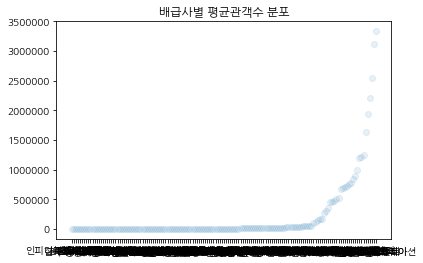

        box_off_num
count       147.000
mean    207_063.657
std     548_692.403
min           2.000
25%       1_036.143
50%       4_997.500
75%      37_187.750
max   3_332_953.929


In [114]:
dist_boxoff = train2.groupby('DROP_distributor').agg({'box_off_num':'mean'}).sort_values('box_off_num') 
plt.scatter(dist_boxoff.index, dist_boxoff.box_off_num, alpha=.1)
plt.title('배급사별 평균관객수 분포')
plt.show()
print(dist_boxoff.describe())

In [115]:
for x in range(10, len(dist_boxoff),5):
    print(x, int(dist_boxoff.iloc[:x]['box_off_num'].mean()))

10 69
15 116
20 188
25 264
30 340
35 416
40 495
45 581
50 670
55 763
60 913
65 1097
70 1289
75 1524
80 1774
85 2099
90 2477
95 2931
100 3605
105 4561
110 5897
115 7600
120 12187
125 23959
130 43271
135 68623
140 103017
145 165431


- 배급사별 평균관객수의 증가추세를 5배급사 간격으로 숫자로 표시해봄.
---

- 여러번의 시행착오로 선택한 결과는 이 "평균관객수/배급사별"을 quantile 기준으로 적절히(선행적으로는 이값 기준으로 평균관객수가 낮은값/높은값을 잘 나누는 어떤 한 값이고, 결과적으로는 러닝결과 에러가 작아지는 값) 값을 기준으로 나누고, 그를 바탕으로 소위 소규모(소 평균관객) 배급사 목록과, 대규모 배급사 목록을 구한다.
- 이후 이 두개의 대/소 배급사 목록을 바탕으로 train 데이터를 두개로 나눠서 각각 머신을 러닝시칸다.
- 이때 각기 다른 머신을 적용할 수도, 혹은 같은 머신의 다른 패러미터 적용으로 러닝시킬수도 있는데, 이번에는 같은 모델/같은 패러미터로 러닝시켰다.
- 예측시에는 test 데이터셋의 배급사 항목을 기준으로, 다시 두 test 데이터셋으로 나눠서, 각각에 맞는 러닝된 머신으로 예측 결과를 얻는다.
- 최종적으로 얻어진 두 세트의 타겟값을 적절히 원래 test 데이터셋의 순에 맞게 배치하면 된다.

---

In [116]:
def show_big_small_distributor(big_limit_percent = 0.75):
    """
    dist_boxoff: 배급사별 평균관객수(box_off_num에 할당)를 담은 데이터프레임.
    big_limit_percent: 이 평균관객수를 대/소로 구분할 퍼센티지 값. 디폴트 0.75
    """
    q_limit = dist_boxoff.box_off_num.quantile(big_limit_percent)
    print('- 배급사별 평균관객수가', q_limit, '명 이상이면 대형 배급사로 구분, (', big_limit_percent, '% )', '\n')

    print('- 대형 배급사별 평균관객수 정보')
    print(dist_boxoff[dist_boxoff.box_off_num > q_limit].describe())
    print('\n- 소형 배급사별, 평균관객수 정보')
    print(dist_boxoff[dist_boxoff.box_off_num <= q_limit].describe())
    
    print('=' * 60)
    
    # set_big_dist, set_sma_dist는 각각 대/소 배급사 목록 set.
    set_big_dist = set(dist_boxoff[dist_boxoff.box_off_num > q_limit].index)
    set_sma_dist = set(dist_boxoff[dist_boxoff.box_off_num <= q_limit].index)

    # 배급사이름이 set_big_dist 안에 포함된다는 'big' 컬럼에 True를 대입한다.
    train2['big'] = train2['DROP_distributor'].apply(lambda x: x in set_big_dist)
    
    print('- train2 데이터셋을 대형 배급사로 모은 후 구한 평균관객수 정보')
    print(train2[train2.big].box_off_num.describe())
    print('- train2 데이터셋을 소형 배급사로 모은 후 구한 평균관객수 정보')
    print(train2[~train2.big].box_off_num.describe())
    
    return set_big_dist, set_sma_dist

- 앞선 "배급사별 평균관객수 분포" 그래프를 봐도, 많은 수의 배급사의 평균관객수가 매우 낮은 부분에 몰려있다.
- 중간값은 고사하고, 75%의 값이 4만명(37_187.750)이 채 되지 않는 분포다.
- 이때 대소를 나눌 quantile 값으로 mean/median 등을 선택하면, 예상컨대 소 배급사 데이터는 큰 오차없이 학습할 것이고, 대 배급사 데이터는 큰 오차를 낼 것이다.
- 빈도는 소 배급사 데이터가 많지만, 타겟값 자체가 워낙 큰 대 배급사의 경우엔 오차값 상승에 큰 영향을 미친다.
- 결론적으로는 이 적절한 나눔값은 test 데이터 예측을 통한 피드백으로 결정될 수 밖에 없다.
- 이번 컴피티션에선 0.9 기준이 낮은 에러를 보였다.
---

- BIG_PERCENTILE의 값은 실제 러닝에서는 모델의 하이퍼패러미터 같은 역할을 하게 된다. 이 값을 0.5~0.95까지 조금씩 변화시켜가면서 예측/제출 반복. 

In [117]:
BIG_PERCENTILE = 0.90

set_big_dist, set_sma_dist = show_big_small_distributor(big_limit_percent=BIG_PERCENTILE)

- 배급사별 평균관객수가 709380.0000000002 명 이상이면 대형 배급사로 구분, ( 0.9 % ) 

- 대형 배급사별 평균관객수 정보
        box_off_num
count        15.000
mean  1_561_626.042
std     873_765.321
min     723_307.500
25%     873_239.083
50%   1_214_237.000
75%   2_074_178.174
max   3_332_953.929

- 소형 배급사별, 평균관객수 정보
       box_off_num
count      132.000
mean    53_136.114
std    141_328.813
min          2.000
25%        866.500
50%      3_550.083
75%     16_995.875
max    700_095.000
- train2 데이터셋을 대형 배급사로 모은 후 구한 평균관객수 정보
count          208.000
mean     1_908_947.418
std      2_702_457.052
min             74.000
25%        246_966.000
50%        974_395.000
75%      2_192_338.250
max     14_262_766.000
Name: box_off_num, dtype: float64
- train2 데이터셋을 소형 배급사로 모은 후 구한 평균관객수 정보
count         392.000
mean       71_040.786
std       280_708.315
min             1.000
25%           745.000
50%         2_634.000
75%        14_967.500
max     2_963_652.000
Name: box_off_num, dtype: float64


- 위 output에서 상단과 하단(=== 기준)의 값들(가령 평균 등)이 차이가 나는데, 상단은 정보를 구한 각 항목이 배급사별 평균관객수가 바탕이다. 따라서 상단에선 대형의 경우 count(빈도수)가 15개(배급사)이고, 소형은 132개로 각각 <배급사>가 기준이 된다.
- 반면 하단의 정보는, 한차례 가공(dist_boxoff 데이터프레임)된 배급사별 평균관중수에서 대소로 나눈 결과(상단)가 아니라, 원래 train2 데이터프레임에서 각 배급사의 대소여부에 따른 평균관객수를 표시한 것이다. 따라서 실제 한 배급사가 다수의 영화에 나타날 수 있으므로, 하단에서는 대형은 208개, 소형은 392개의 <개별영화>가 기준이 된다.
- 그냥, 상단은 groupby('배급사'), 하단은 groupy('개별영화')로 먼저 그룹지은 후에 다시 그 각각을 groupby(관객수)로 모아서 산술정보를 계산한 식이다.
---

In [118]:
test_set_dist = set(test2.DROP_distributor.unique())
test_set_big_dist = set_big_dist & test_set_dist
# test_set_sma_dist = set_sma_dist & test_set_dist
test2['big'] = test2['DROP_distributor'].apply(lambda x: x in test_set_big_dist)

print('- test2 데이터셋을 대형 배급사로 모은 후, 구한 평균관객수 정보')
print(test2[test2.big].DROP_distributor.describe())
print('\n- test2 데이터셋을 소형 배급사로 모은 후, 구한 평균관객수 정보')
print(test2[~test2.big].DROP_distributor.describe())

- test2 데이터셋을 대형 배급사로 모은 후, 구한 평균관객수 정보
count        87
unique        9
top       CJCGV
freq         32
Name: DROP_distributor, dtype: object

- test2 데이터셋을 소형 배급사로 모은 후, 구한 평균관객수 정보
count        156
unique        74
top       마운틴픽쳐스
freq          15
Name: DROP_distributor, dtype: object


- test2 데이터셋에서 대소 배급사를 구분할 땐, train2에서의 대형 배급사에 속하는 배급사만 "대형"으로 구분하고, 나머지(train2에서의 소형, 혹은 train2에 없던 새로운 배급사인 경우)는 모두 소형으로 간주.
---

- train2/test2에는 'big' 컬럼이 대소배급사 구분값을 가지고 있다.

In [119]:
total = pd.concat([train2, test2], ignore_index=True)
total.tail().T

,838,839,840,841,842
DROP_dir_prev_bfnum,2_590.000,NaN,NaN,50_699.000,NaN
DROP_director,안슬기,이일하,안용훈,송동윤,이전
DROP_distributor,디씨드,인디스토리,컨텐츠온미디어,씨타마운틴픽쳐스,케이알씨지
DROP_genre,드라마,다큐멘터리,느와르,드라마,멜로/로맨스
DROP_num_actor,4,2,4,7,4
DROP_release_month,11,10,10,10,10
DROP_release_time,2015-11-19,2015-10-29,2015-10-28,2015-10-22,2015-10-22
DROP_screening_rat,15세 관람가,12세 관람가,청소년 관람불가,청소년 관람불가,청소년 관람불가
DROP_time,78,86,107,102,76
DROP_title,해에게서 소년에게,울보 권투부,어떤살인,말하지 못한 비밀,조선안방 스캔들-칠거지악 2


- 이제 total 데이터프레임은 big 컬럼까지 가진 최종의 것으로 할당되었다.
---

In [120]:
total.drop(drop_cols, axis=1, inplace=True)
total.head().T

,0,1,2,3,4
box_off_num,23_398.000,7_072_501.000,6_959_083.000,217_866.000,483_387.000
dir_prev_bfnum_category,True,False,False,False,False
dir_prev_num_category,cat0,cat2,cat4,cat2,cat1
director_category,cat1,cat4,cat2,cat1,cat1
distributor_ord,5.000,5.000,5.000,5.000,5.000
genre_scaled,6.343,6.355,6.343,6.077,6.077
num_staff,91,387,343,20,251
release_month_ord,3.000,3.000,4.000,9.000,3.000
screening_rat_scaled,0.292,0.292,1.000,0.108,1.000
time_trend,0.016,0.716,0.495,0.044,0.131


- 최종적으로 삭제할 컬럼들(drop_cols)를 데이터프레임에서 삭제한다.
---

In [121]:
total = pd.get_dummies(total)
total.head().T

,0,1,2,3,4
box_off_num,23_398.000,7_072_501.000,6_959_083.000,217_866.000,483_387.000
distributor_ord,5.000,5.000,5.000,5.000,5.000
genre_scaled,6.343,6.355,6.343,6.077,6.077
num_staff,91,387,343,20,251
release_month_ord,3.000,3.000,4.000,9.000,3.000
screening_rat_scaled,0.292,0.292,1.000,0.108,1.000
time_trend,0.016,0.716,0.495,0.044,0.131
"title_(0, 1_",0,0,0,0,0
"title_(1, 5_",1,1,0,0,1
"title_(5, 9_",0,0,1,1,0


- pd.get_dummies() 메소드로 카테고리 컬럼을 one-hot-encoding 시킨다. (이를 위해 일부 숫자로 된 카테고리는 값으로 'cat'을 덧붙여 문자열로 만들었다.)
---

In [122]:
train_new = total[~total.box_off_num.isna()]
test_new  = total[total.box_off_num.isna()]

print(len(train_new), len(test_new)) # 각각 600개 243개로 문제가 없다.

600 243


- train_new/test_new로 새로 훈련/테스트셋으로 나눈다.
---

### 훈련/테스트셋을 각기 대소 배급사(big 칼럼)를 기준으로 두 그룹으로 나누기

In [123]:
train_new_big = train_new[train_new.big]
test_new_big  =  test_new[test_new.big]

train_new_sma = train_new[~train_new.big]
test_new_sma  =  test_new[~test_new.big]

- 'big' 칼럼은 feature가 아니라, 두 그룹으로 나누기 위한 기준값이었으므로, 나눈 후에는 이 칼럼도 삭제한다. (물론 넓은 의미로는 이 big값이 feature역할을 하게 됨. 각기 다른 머신 러닝을 하게 만드는 요소이므로)

In [124]:
X_tr_big = train_new_big.drop(['box_off_num', 'big'], axis=1)
y_tr_big = train_new_big.box_off_num
X_te_big =  test_new_big.drop(['box_off_num', 'big'], axis=1)

X_tr_sma = train_new_sma.drop(['box_off_num', 'big'], axis=1)
y_tr_sma = train_new_sma.box_off_num
X_te_sma =  test_new_sma.drop(['box_off_num', 'big'], axis=1)

- 정리하자면, 평균관객수가 많은 배급사룰 거잔 영화들을 각각 X_tr_big, X_te_big으로 훈련/테스트셋을 나누고, 적은 배급사는 각각 X_tr_sma, X_te_sma로 나눴다.
---

### 테스트셋에서 대/소 그룹별 행(row)의 인덱스 저장하기

- 아래 과정의 설명: 
- 테스트셋을 대소 기준으로 두 그룹으로 나눠서 해당 머신에 입력해서 각각 예측값을 얻게 되는데, 문제는 이렇게 각기 구한 **예측값을 원래 테스트셋의 순서에 맞게 재배치**해서 제출해야 된다는 것이다.
- 이를 위한 과정.

In [125]:
test_new_for_mapping = test_new.copy()
test_new_for_mapping.head()

,box_off_num,distributor_ord,genre_scaled,num_staff,release_month_ord,screening_rat_scaled,time_trend,"title_(0, 1_","title_(1, 5_","title_(5, 9_",...,dir_prev_num_category_cat1,dir_prev_num_category_cat2,dir_prev_num_category_cat3,dir_prev_num_category_cat4,dir_prev_num_category_cat5,dir_prev_num_category_cat6,director_category_cat1,director_category_cat2,director_category_cat3,director_category_cat4
600,nan,5.000,6.355,304,11.000,0.292,0.558,0,1,0,...,0,1,0,0,0,0,0,1,0,0
601,nan,5.000,5.629,275,11.000,0.677,0.193,0,0,1,...,0,0,0,1,0,0,1,0,0,0
602,nan,5.000,5.796,419,11.000,0.677,0.218,0,1,0,...,0,0,1,0,0,0,1,0,0,0
603,nan,5.000,6.343,408,6.000,1.000,0.230,0,1,0,...,0,1,0,0,0,0,0,1,0,0
604,nan,5.000,5.771,380,6.000,1.000,0.156,0,1,0,...,1,0,0,0,0,0,0,1,0,0


- 애초에 훈련셋과 테스트셋을 concatenate한 것을 다시 test_new로 나눈 것이므로, test_new 데이터프레임의 index 값은 600(훈련셋의 갯수600)부터 시작하게 된다.
---

In [126]:
test_new_for_mapping.big.head()

600    True
601    True
602    True
603    True
604    True
Name: big, dtype: bool

In [127]:
test_new_for_mapping = test_new_for_mapping.big.reset_index()
test_new_for_mapping.head()

,index,big
0,600,True
1,601,True
2,602,True
3,603,True
4,604,True


- reset_index()를 해서, 600부터 시작하는 index 값을 컬럼으로 취했다.
---

In [128]:
test_new_for_mapping['index'] -= 600 # "index" 컬럼의 값이 0부터 시작하도록 변경.
test_new_for_mapping.head()

,index,big
0,0,True
1,1,True
2,2,True
3,3,True
4,4,True


In [129]:
test_big_mapping = test_new_for_mapping[test_new_for_mapping.big]['index'].values
test_big_mapping

array([  0,   1,   2,   3,   4,   9,  14,  15,  17,  18,  19,  25,  27,
        30,  42,  44,  45,  48,  51,  53,  54,  57,  58,  59,  60,  61,
        66,  67,  68,  70,  71,  73,  76,  77,  81,  83,  85,  89,  92,
        93,  94,  98,  99, 100, 101, 103, 104, 105, 106, 108, 111, 112,
       115, 117, 121, 122, 131, 134, 135, 137, 138, 141, 142, 148, 149,
       158, 159, 161, 162, 163, 166, 178, 179, 184, 195, 197, 199, 205,
       206, 207, 209, 211, 212, 216, 221, 222, 229])

In [130]:
test_sma_mapping = test_new_for_mapping[~test_new_for_mapping.big]['index'].values
test_sma_mapping

array([  5,   6,   7,   8,  10,  11,  12,  13,  16,  20,  21,  22,  23,
        24,  26,  28,  29,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  43,  46,  47,  49,  50,  52,  55,  56,  62,  63,  64,
        65,  69,  72,  74,  75,  78,  79,  80,  82,  84,  86,  87,  88,
        90,  91,  95,  96,  97, 102, 107, 109, 110, 113, 114, 116, 118,
       119, 120, 123, 124, 125, 126, 127, 128, 129, 130, 132, 133, 136,
       139, 140, 143, 144, 145, 146, 147, 150, 151, 152, 153, 154, 155,
       156, 157, 160, 164, 165, 167, 168, 169, 170, 171, 172, 173, 174,
       175, 176, 177, 180, 181, 182, 183, 185, 186, 187, 188, 189, 190,
       191, 192, 193, 194, 196, 198, 200, 201, 202, 203, 204, 208, 210,
       213, 214, 215, 217, 218, 219, 220, 223, 224, 225, 226, 227, 228,
       230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242])

In [131]:
len(test_big_mapping), len(test_sma_mapping)

(87, 156)

- 테스트셋의 대소 구분에 의한 데이터들의 index값을 차례대로 배열로 저장.
- 다만 원래 테스트셋에서의 선후 순서는 유지하면서 big/sma 그룹으로 나누어야 한다는 제한은 있지만, 그룹 분리나 예측 시 입력데이터로 사용할때 셔플하지 않기에 문제없음.

# 5. Modelling & Learning

- **이 Ch.5 부분은 노트북 맨 밑( main()함수 )에서부터 차례로 위로 올라가면서 보면 됩니다.**
- 이 Ch.5 부분은 노트북 맨 밑( main()함수 )에서부터 차례로 위로 올라가면서 보면 됩니다.
- **이 Ch.5 부분은 노트북 맨 밑( main()함수 )에서부터 차례로 위로 올라가면서 보면 됩니다.**
- 이 Ch.5 부분은 노트북 맨 밑( main()함수 )에서부터 차례로 위로 올라가면서 보면 됩니다.
- **이 Ch.5 부분은 노트북 맨 밑( main()함수 )에서부터 차례로 위로 올라가면서 보면 됩니다.**

In [132]:
import keras
from keras import backend as K
from keras import layers
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import Adam, RMSprop, SGD, Adagrad

from sklearn.model_selection import ShuffleSplit, KFold, LeaveOneOut
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import ShuffleSplit, KFold, LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from keras.layers.normalization import BatchNormalization
from sklearn.preprocessing import MinMaxScaler, RobustScaler, Normalizer, StandardScaler

# 실제 이 노트북에선 사용되지 않는 리그레서들.
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.neural_network import  MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

Using TensorFlow backend.


---
- 타겟 예측값과 실제값사이의 RMSE를 구하는 함수
- root_mean_squared_error()는 Keras의 러닝 과정에서 사용자 정의 Metrics로 사용하기 위한 것이고,
- np_root_mean_squared_error()는 Numpy 배열형태로 존재하는 값을 이용해, 수동으로 RMSE를 얻기 위해 사용하는 루틴.

In [133]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

def np_root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true))) 

---
- **multi_layers_model_with_BN()** 함수:
    - 소형 배급사 데이터셋에 적용하고자 강구된 NN 빌드함수.
    - 소형 훈련세트에 대한 에러가 상대적으로 더 크게 나타나길레, NN 모델을 조금더 복잡하게 해봄.
    - 각 레이어의 크기, 층수, 드랍아웃 비율, BatchNormalization 층 추가 등등은, 각 하이퍼패러미터를 기준으로 grid search 하지는 못했고, 수동으로 적당한 값들 변경으로 나타난 값들이다.
    - 따라서 최적(?)의 패러미터라고 보긴 어렵다.

In [134]:
def multi_layers_model_with_BN():
    layer1_size = 128*2
    layer2_size = 32*2
    
    reg1 = None
    reg2 = regularizers.l1(0.001)
    model = keras.models.Sequential()
    model.add(layers.Dense(layer1_size, kernel_initializer='he_normal', kernel_regularizer=reg1, input_dim=features_n)) 
    model.add(layers.BatchNormalization()) 
    model.add(layers.Activation('relu'))
    
    model.add(layers.Dropout(rate=dropout_rate, seed=42)) 
    
    model.add(layers.Dense(layer2_size, kernel_regularizer=reg2, kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    
    model.add(layers.Dense(1, activation='linear', kernel_initializer='normal'))
    
    model.compile(optimizer=optimizer, loss=loss_func, metrics=[metrics_func])
    return model

---
- **learn_sma()** 함수:
    - learn_big()과 같은 과정을 수행한다.
    - 복잡해진 NN(**multi_layers_model_with_BN**) 때문에 **num_epochs을 두배로 증가**시킨 점만 다르다.

In [135]:
def learn_sma():

    global num_epochs, n_splits, batch_size, dropout_rate, loss_func, metrics_func, features_n
    global hist_tra, hist_val, x_scaler, y_scaler, regressor, outfile_name, optimizer
    
    features_n = len(X_tr.columns)
    
    # learn_big()의 에폭보다 두배로 늘렸다. 복잡해진 NN때문.
    num_epochs = 400 #<-------------------------------------------------------------- learn_big()과 다른 부분.
    n_splits   = 2
    batch_size = 20
    dropout_rate = 0.5

    loss_func = 'mse'
    metrics_func = root_mean_squared_error
    hist_tra = 'root_mean_squared_error'
    hist_val = 'val_root_mean_squared_error'
    
    optimizer = Adam(lr=0.0001)
    print('- Adam 옵티마이저의 설정값 =', optimizer.get_config(), '\n')
        
    x_scaler = StandardScaler()
    y_scaler = RobustScaler()
    
    print("- NN 모델 Summary:")
    print(multi_layers_model_with_BN().summary())
    
    regressor = KerasRegressor(build_fn=multi_layers_model_with_BN) #<--------------- learn_big()과 다른 부분.

    learn_and_predict_box_office()

---
- **add_prediction_to_submission()** 함수:
    - 전체 훈련데이터를 통해 최적의 epoch내에서 러닝된 리그레서(regressor)를 입력 받아서, 테스트 데이터(X)의 예측값을 구한다.
    - 이 값은 러닝 전에, scale --> log1p 되었기에, 예측값을 다시 expm1 --> scaler.inverse_transform 시켜준다.
    - 이 후에 **별도의 부가처리**를 해준다. 이 부분은 리그레서/스케일러 등을 바꾸면서 실험하는 동안에, 최종 변환된 타겟값(관객수)이 음수(-)가 되는 경우가 있었기에, 이런 경우에 음수인 타겟값을 나머지 값들의 중간값으로 치환하는 처리를 해줬었는데, 현재 노트북의 스케일러/리그레서 상에선 이런 경우는 없었던 것 같다. 다만, 혹시 모를 예비책으로 계속 존재시킴.
    

In [136]:
def add_prediction_to_submission(regressor=None, X=None):
    def deal_with_negative(x):
        if x < 0:
            x = 0
        return x
    def deal_with_zero(x):
        if x == 0:
            x = median
        return x
    
    y_pred = regressor.predict(X)
    # exp --> scale.
    y_pred = np.expm1(y_pred)
    predictions = y_scaler.inverse_transform(y_pred.reshape(-1,1))

    
    # 별도의 부가처리.
    # 타겟 예측값이 음수(-)이면 먼저 그 값을 0으로 치환한 후, 전체 데이터의 중간값(median)을 구한 후, 다시 0인 값을 median 값으로 치환하는 처리.
    # 주로 사용하는 스케일러 혹은 스케일/로그화 순서 변경 등에서 음수값이 나타나는 경우가 있어서 대비책으로 마련.
    tmp_df = pd.DataFrame(predictions, columns=['box_off_num'])
    median = tmp_df.box_off_num.apply(deal_with_negative).median()
    tmp_df.box_off_num = tmp_df.box_off_num.apply(deal_with_negative).apply(deal_with_zero)

    # 대/소 구분에 따라 나눈 데이터셋으로 러닝, 예측을 하고 나서, 그 예측값을 원래 테스트셋의 영화항목 순서에 맞게 끼워맞춰야 한다.
    # 이를 위해 대/소 러닝 전에 submission_flag 변수에 big/sma을 대입해서 현재 러닝 대상을 알린 후,
    # 그 값에 따라서 앞서 준비했던 테스트셋의 인덱스맵핑을 알맞게 선택한후, **차례대로** submission 데이터프레임에 대입한다.
    if submission_flag == 'big':
        maps = test_big_mapping
    else:
        maps = test_sma_mapping
    
    # 인덱스 맵핑 리스트의 값에 따라, **차례대로** 대입해야 섞이지 않음. 
    for i in range(len(predictions)):
        idx = maps[i]
        df_submission_src.loc[idx, 'box_off_num'] = tmp_df.loc[i, 'box_off_num']

---
- **do_training_with_full_train_data()** 함수:
    - 앞서 exploit_epochs() 함수로 주어진 epochs 내에서, cv 검증 에러가 최소가 되는 최적 에폭을 구했다.
    - 그후 이 함수에서는 kfold로 나눈 훈련데이터가 아닌, 전체 훈련데이터를 이용해 다시 리그레서를 최적 에폭까지 러닝시킨다.
    - 러닝 과정에서 훈련데이터의 RMSE 에러 변화를 그래프로 그려준다.
    - 마지막으로 전체훈련데이터의 RMSE를 계산해 출력한다.

In [137]:
def do_training_with_full_train_data(regressor=None, X=None, y=None):
    print('\n- 전체 train데이터셋을 이용해, 최소 epochs까지 러닝...')
    history = regressor.fit(X, y)

    tra_rmse_history = history.history[hist_tra]
    plt.plot(range(1, len(tra_rmse_history)+1), tra_rmse_history, 'r')
    plt.show()
    
    y_tr_pred = regressor.predict(X)
    print("\n전체 train 데이터로 최적 epoch까지 훈련한 결과 RMSE는 {} 입니다.\n".format(np_root_mean_squared_error(y.flatten(), y_tr_pred.flatten())))

---
- **exploit_epochs()** 함수:
    - 훈련데이터를 kfold로 나눠서 훈련시키고, 나머지 검증폴드로 검증계산을 하는 과정을 kfold별로 num_epochs 에폭만큼 러닝을 반복한다.
    - 그 과정에서 loss/validation lss/metrics/validation metrics 등이 history에 저장이 된다.
    - kfold로 데이터를 폴드로 나눠서 각 폴드에 대해서 epochs이 진행된다.
    - all_tra_rmse_history/all_val_rmse_history 리스트에는, 각 folds 별로 진행된 epoch 과정에서 RMSE 값들이 담겨있다.
    - average_tra_rmse_history/average_val_rmse_history 리스트는, 각 folds의 RMSE 값(all_...리스트)을 같은 epoch 기준으로 평균을 내서, epoch 변화에 따른 평균 훈련/검증 RMSE로 재정렬한 것이다. 즉 all_...이 담고있는 folds->epochs별로 된 RMSE 값들을, average_...는 epochs->folds평균RMSE. 이유는 epochs기준으로 그래프를 그리기 위해.
    - 검증 에러가 최소가 되는 epoch 값을 반환한다.

In [138]:
def exploit_epochs(X=None, y=None, kfold=None, model=None, regressor=None, epochs=None):
    print('\n- 최소/최적 epochs 계산...\n')
    
    # 리스트 리셋.
    all_tra_rmse_history.clear()
    all_val_rmse_history.clear()
   
    # kfold로 훈련/타겟을 split한 후에, split된 훈련데이터로 regressor에 설정된 에폭만큼 반복해서
    #   - 러닝한 후,
    #   - 러닝된 리그레서를 이용해 나머지 holdout된 검증데이터를 이용해 RMSE에러를 계산한다.
    #   - 러닝과정/검증과정의 각 loss/metrics는 history에 저장되어 반환된다.
    for train_index, val_index in tqdm_notebook(kfold.split(X, y)):
        history = regressor.fit(
            X.iloc[train_index],
            y[train_index],
            validation_data=(X.iloc[val_index], y[val_index]))

        # 한 fold별 훈련/검증 데이터를 리스트에 추가한다.
        # 따라서 all_tra_rmse_history/all_val_rmse_history 리스트의 가장 최상의 인덱스는, epoch별이 아니라 fold별이다.
        # 실제 에폭별 그래프를 그리기 위해선, 이를 다시 epoch별 fold의 에러 평균으로 재정렬하는 과정을 거친다.(plot_epochs_rmse_history 함수 내에서)
        all_tra_rmse_history.append(history.history[hist_tra])
        all_val_rmse_history.append(history.history[hist_val])

    # folds->epochs 를 epochs->folds평균으로 재정렬.
    average_tra_rmse_history = [np.mean([x[i] for x in all_tra_rmse_history]) for i in range(epochs)]
    average_val_rmse_history = [np.mean([x[i] for x in all_val_rmse_history]) for i in range(epochs)]

    plt.plot(range(1, len(average_tra_rmse_history)+1), average_tra_rmse_history, 'r')      
    plt.plot(range(1, len(average_val_rmse_history)+1), average_val_rmse_history, 'b')
    plt.show()
    
    # 검증 RMSE가 최소가 되는 인덱스(argmin), 즉 에폭을 반환.
    return np.argmin(average_val_rmse_history)

---
- **do_data_scaling()** 함수:
    - 실질적으로는 X_tr, y_tr, X_te가 이 함수의 입력값이다. 다만 편리성을 위해 함수의 인자로 전달하지 않고, 전역변수로 처리했다.
    - 훈련데이터(X_tr)를 바탕으로 fitting을 한 후, 이를 바탕으로 X_tr_scaled/X_te_scaled 두 데이터를 모두 스케일 변환한다.
    - 이때 사용될 스케일 방법은 x_scaler/y_scaler 객체로 함수 외부에서 미리 설정하고 호출한다.
    - 훈련데이터의 **타겟값(y_tr)에 대한 스케일**은 y_scaler에 의한 스케일링 외에 추가로,"**로그화**"를 진행한다. 이는 타겟값(관객수)의 범위가 너무 넓어서
    정규분포에 가깝지 않고 한쪽으로 치우쳐진 상태라, 이를 보강하기 위한 추가변환이다. (반대로 먼저 로그화 후에 스케일, 스케일만 등으로 모두 시도해본 결과, **스케일링 후 로그화**가 좋은 결과가 나와서 채택)
    - 따라서 테스트셋에 대해 예측을 한 후의 값을 다시 exponentialize하는 하는 것을 누락하면 안된다.
    구체적인 변환은 **log1p(x) <--> expm1(x)**이다. (log(1+x) <--> exp(x)-1) 관계).

In [139]:
def do_data_scaling():
    print('\n- 데이터 스케일링...\n')
    x_scaler.fit(X_tr)
    y_scaler.fit(y_tr.values.reshape(-1,1))

    global X_tr_scaled, X_te_scaled, y_tr_scaled
    # 훈련/테스트 데이터 모두 훈련데이터를 기준으로 fitting한 결과로 스케일한다.
    X_tr_scaled = pd.DataFrame(x_scaler.transform(X_tr), columns=X_tr.columns)
    X_te_scaled = pd.DataFrame(x_scaler.transform(X_te), columns=X_te.columns)

    # scale --> log.
    y_tr_scaled = y_scaler.transform(y_tr.values.reshape(-1,1)) # scaler에 의한 scaling.
    y_tr_scaled = np.log1p(y_tr_scaled) # log화.

---
- **learn_and_predict_box_office()** 함수:
    - 러닝 전에 데이터/타겟값을 스케일링 한다.
    - num_epochs까지 folds 별로 러닝(folds-1 폴드의 훈련데이터 이용)/검증을 수행한 후, 검증 에러가 최소가 되는 epoch을 구한다.
    - 이제 이 구한 epoch까지, 전체 훈련데이터를 이용해 러닝 시킨 후, 그 훈련된 리그레서로 테스트 타겟값을 예측/저장한다.

In [140]:
def learn_and_predict_box_office():
    # step.1: 
    # 훈련/테스트셋, 타겟값에 대한 스케일링 작업. NN 특성상 고른 입력값으로 준비.
    do_data_scaling()

    # step.2:
    # num_epochs 이내에서 validation RMSE error가 최소가 되는 epochs_opt를 구한다.
    regressor.set_params(batch_size=batch_size, epochs=num_epochs, verbose=False) # 리그레서의 패러미터 설정. 각 값들은 이 루틴 밖의 global한 값.
    epochs_opt = exploit_epochs(
        X=X_tr_scaled,
        y=y_tr_scaled,
        epochs=num_epochs,
        regressor=regressor,
        kfold=KFold(n_splits=n_splits, shuffle=True, random_state=42)
    )
    print('최소 epochs_opt는 {}입니다.'.format(epochs_opt))

    # step.3:
    # 리그레서가 앞서 구한 epochs_opt 에폭까지만 러닝하도록 설정한후, 전체 훈련데이터를 사용해 러닝.
    regressor.set_params(batch_size=batch_size, epochs=epochs_opt, verbose=False)
    do_training_with_full_train_data(
        regressor=regressor,
        X=X_tr_scaled,
        y=y_tr_scaled)

    # step.4:
    # 훈련된 리그레서를 이용해, 테스트 데이터의 예측값을 계산 후, submission용 파일로 저장.
    add_prediction_to_submission(regressor=regressor, X=X_te_scaled)

---
- **simple_layer_model()** 함수:
    - NN을 빌드하는 함수, KerasRegress 생성시 내부적으로 호출되면, 생성한 model을 반환하는 역할.
    - 이 심플레이어 모델은 입력과 출력 두 레이어로만 구성됨.
    - 여러 러닝 과정 중에는 Dropout/중간층/층크기/레귤라이저 종류 등에 변화를 줘 봤지만, 현재 모델로 에러가 낮아서 이용됨.

In [141]:
def simple_layer_model():
    layer1_size = 128
    layer2_size = 32*2
    
    reg1 = None
    model = keras.models.Sequential()
    model.add(layers.Dense(layer1_size, activation='relu', kernel_initializer='normal', kernel_regularizer=reg1, input_dim=features_n)) 
    model.add(layers.Dense(1, activation='linear', kernel_initializer='normal'))
    
    model.compile(optimizer=optimizer, loss=loss_func, metrics=[metrics_func])
    return model

---
- **learn_big()** 함수:
    - 데이터/타겟에 대한 각각의 **스케일러 지정**
    - 사용할 Neural Network(NN)를 Sklearn 툴 내에서 사용하기 위해 **KerasRegressor 선택**. 
    - 참고로 Sklearn 내의 각종 리그레서와 이를 Stacking한 모델 등으로 시도해봐도, 이 모델보다 에러가 높게 나왔음.
    - 기타 설정 값들은, 사실 NN를 빌드하는 루틴 내에서 지정해되 되는 값들인데, 다만 big/sma 각각의 러닝에 대해 각기 다른 설정값을 지정할 가능성에 대비해 NN빌드 루틴 밖, 이곳에서 설정하도록 했다.
    - 이 함수는 실제 러닝에 필요한 리그레서 생성과 기타 관련 하이퍼패러미터를 설정하는게 주목적이고, 실제 러닝은 learn_and_predict_box_office() 함수에서 수행된다.
    

In [142]:
def learn_big():
    # 편의를 위해, 많은 경우 함수 인자 대신에 전역변수로 처리했다.
    global num_epochs, n_splits, batch_size, dropout_rate, loss_func, metrics_func, features_n
    global hist_tra, hist_val, x_scaler, y_scaler, regressor, outfile_name, optimizer
    
    # feature 갯수 (이는 NN의 첫 레이어의 입력갯수를 정하는데 사용된다.
    features_n = len(X_tr.columns)
    
    num_epochs = 200
    n_splits   = 2  # CV를 위한 folds는 보통 5,10을 사용하는데, 초반 빠른 결과를 위해 시도해돈 2값이 오히려 에러가 적게 나와서 2 사용.
    batch_size = 20

    # Loss function으로 MSE 선정.
    loss_func = 'mse'
    # 러닝 과정에서 계산할 메트릭으로는 사용자 정의한 RMSE 함수 지정.
    metrics_func = root_mean_squared_error
    # history에서 훈련데이터로 계산한 RMSE 메트릭에 대한 Key 이름.
    hist_tra = 'root_mean_squared_error'
    # history에서 검증데이터로 계산한 RMSE 메트릭에 대한 Key 이름.
    hist_val = 'val_root_mean_squared_error'
    
    # Adam 옵티마이저 사용.
    # 옵티미이저를 NN 빌드 함수 내에서 직접 지정하지 않고 여기서 한 이유는, big/sma 별로 다른 옵티~를 설정할 가능성에 대비해서다.
    # 다만, 실제 결과물 노트북에선 둘다 같은 패러미터의 옵티마이저를 사용.
    optimizer = Adam(lr=0.0001)
    print('- Adam 옵티마이저의 설정값 =', optimizer.get_config(), '\n')
    
    # 데이터에 대한 스케일러 지정. 이 선정된 Scaler는 Normalizer, MinMaxScaler 등 몇가지를 테스트한 후에 결과를 바탕으로 선정된 것.
    x_scaler = StandardScaler()
    # 훈련데이터의 타겟값에 대한 스케일러 지정.
    y_scaler = RobustScaler()
    
    print("- NN 모델 Summary:")
    print(simple_layer_model().summary())
    
    # KerasRegressor 이용.
    regressor = KerasRegressor(build_fn=simple_layer_model)
    
    # KerasRegressor 모델을 이용해 러닝 및 예측.
    learn_and_predict_box_office()

---
- **main()** 함수:
    - 크게 두번(big/sma 데이터셋 각각)의 루프를 반복하면서, 두번의 러닝/예측을 실시한다.
    - 결과를 CSV로 저장하고, 총 소요시간을 출력.

In [143]:
def main():
    # 초반 노트북 작성시에는 함수로 나누지 않고 작성한 것을, 가독성있게 함수로 나누고 하는 과정에서 각 변수를 함수의 parameter로 정리하려니 너무 복잡해지고
    # 자칫 에러가 생길까봐, 그냥 global로 처리했음.
    global X_tr, y_tr, X_te, X_tr_big, y_tr_big, X_te_big, X_tr_sma, y_tr_sma, X_te_sma, start_time
    global all_val_rmse_history, all_tra_rmse_history, features_n, df_submission_src, submission_flag
    
    # epoch 마다, validation의 rmse 이력을 저장하는 리스트.
    all_val_rmse_history = []
    # epoch 마다, training의 rmse 이력을 저장하는 리스트.
    all_tra_rmse_history = []
    # submission CSV 읽음.
    df_submission_src = pd.read_csv('./submission.csv')

    for flag in ["big", "sma"]:
        submission_flag = flag

        # learning 관련한 루틴들은 모두 입력이 X_tr, 타겟이 y_tr, 테스트가 X_te로 가정하고 진행됩니다.
        # 이에 맞게 big/sma인 경우 각각의 데이터셋을 맞게 할당하는 과정.
        if flag == 'big':
            X_tr = X_tr_big
            y_tr = y_tr_big
            X_te = X_te_big
        else:
            X_tr = X_tr_sma
            y_tr = y_tr_sma
            X_te = X_te_sma   

        print('\n' * 5)
        print("=" * 80)
        print("=" * 80)
        print("=" * 80)
        print("submission_flag는", flag)
        print("=" * 80)
        print("=" * 80)
        print("=" * 80)
        print('\n\n- train 데이터 갯수 =',len(X_tr), ', test 데이터 갯수 =', len(X_te), '\n')

        if flag == 'big':
            learn_big()
        else:
            learn_sma()

    # 루틴 반복시, 출력 csv가 겹치지 않도록.
    outfile_name = './lee-kyung-joon-submission-{}.csv'.format(datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
    df_submission_src.to_csv(outfile_name, index=False)
    print('\n- 제출 파일 {}를 저장했습니다...\n'.format(outfile_name))
    print('\n')
    print('\n- 제출할 예측 데이터의 정보.\n')
    print(df_submission_src.describe())

    elapsed = timeit.default_timer() - start_time
    mins, secs = divmod(elapsed, 60)
    print('\n\n노트북 총 소요시간 = %d분 %d초\n' % (mins, secs))

---
### 대략적인 전체 흐름 설명.

- main() 함수를 호출 하기 전에 미리 준비되어 있어야 하는 데이터 상황
    - EDA&FE를 통해 원본 데이터 컬럼을 머신러닝을 위한 feature로 변환 완료.
    - 배급사(distributor)별 평균관객수를 기반으로, 평균관객수가 큰 그룹과 작은 그룹으로 훈련/테스트셋이 나눠져 있어야 함.
        - 대형 배급사 데이터셋 그룹: X_tr_big, y_tr_big, X_te_big
        - 소형 배급사 데이터셋 그룹: X_tr_sma, y_tr_sma, X_te_sma
        - 즉 len(X_tr) = len(X_tr_big) + len(X_tr_sma) 식이다.
        - 이때 나누는 기준 값이 BIG_PERCENTILE=0.9, 이 값은 넓은 의미로 하이퍼패러미터가 되어, 이를 조정해서 최종에러를 줄이는 반복잡업을 진행한다.
- **main()**의 역할:
    - 대소 배급사 기준 두 데이터셋 그룹에 대해, 다른 모델로 각각 러닝/예측(**learn_big/learn_sma**)한다.
    - 대소 데이터셋 그룹에 대해, 이 노트북에서 실제 사용하는 러닝/예측 과정 거의 같다. 구성하기에 따라서는, 두개가 별개이므로 각각 다른 머신러닝 알고리즘으로 구성하거나 등등으로 할 수 있지만, 이 노트북에서는 전체적인 러닝 과정은 동일하고 다만 뉴럴네트워크 구성을 단순/약간복잡하게 구성한 정도의 차이만 뒀다.
- **learn_big/sma()** 역할:
    - 러닝에 필요한 "Optimizer", "Scaler", "KerasRegressor에서 사용할 NN 모델" 지정 등을 한 후에, 실제 메인 러닝 루틴인 **learn_and_predict_box_office()** 호출한다.
    - Optimizer, Scaler 등은 NN 모델 구성 함수(simple_layer_model/multi_layers_model_with_BN)에서 직접 지정해도 되지만, 이 종류도 hyperparameter화 해서, 반복적인 선택과정을 프로그램적으로 지정할 가능성을 위해, 이곳에서 러닝전에 일괄 지정하도록 한것.
- **learn_and_predict_box_office()** 역할:
    - 데이터 스케일링 작업(**do_data_scaling()**):
        - 훈련데이터의 타겟(y)값의 큰 범위 때문에 log화하는 등 추가 작업. 이제 러닝에 필요한 완전한 데이터 준비 끝.
    - 최적/최소 epochs 값 구하기(**exploit_epochs()**): 
        - 훈련데이터를 kfolds로 나눠서, 훈련/검증을 num_epochs(200/400)만큼 진행한다. 그 과정 중에 얻는 history값을 이용해서, 전체 num_epochs 내에서 검증RMSE가 최소가 되는 epochs_opt 값을 얻는게 목적.
    - 리그레서를 최종 러닝시킴(**do_training_with_full_train_data()**): 
        - 앞서 얻은 epochs_opt 에폭까지 전체훈련데이터를 이용해 다시 러닝. 
    - 최종 러닝된 리그레서로 예측 및 저장(**add_prediction_to_submission()**):
        - 예측한 후 다시 그 값을 역변환(scale-->log의 역순) 시킨 후,
        - 제출csv 데이터프레임의 해당되는 행(index)에 순차적으로 예측값 대입.
            - 테스트셋을 대소(big/sma) 기준에 맞춰서 두 그룹으로 나눠서 예측했기에, 여기서 문제는 예측한 값들을 원래 테스트셋의 원래 위치에 맞게 대입하는 것인데, 이를 위해 Data Preparation 마지막 과정에서 해당 index를 순차적으로 대/소에 맞게 각각 저장해뒀다. 이를 이용해 순차적으로 저장하면 됨.
    







submission_flag는 big


- train 데이터 갯수 = 208 , test 데이터 갯수 = 87 

- Adam 옵티마이저의 설정값 = {'lr': 9.999999747378752e-05, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False} 

- NN 모델 Summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               3072      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 3,201
Trainable params: 3,201
Non-trainable params: 0
_________________________________________________________________
None

- 데이터 스케일링...


- 최소/최적 epochs 계산...



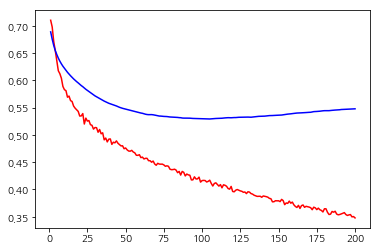

최소 epochs_opt는 104입니다.

- 전체 train데이터셋을 이용해, 최소 epochs까지 러닝...


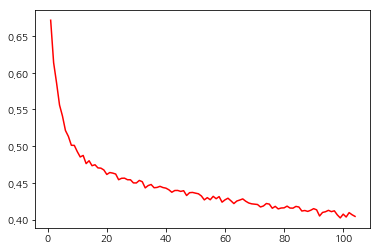


전체 train 데이터로 최적 epoch까지 훈련한 결과 RMSE는 0.4098438899035622 입니다.







submission_flag는 sma


- train 데이터 갯수 = 392 , test 데이터 갯수 = 156 

- Adam 옵티마이저의 설정값 = {'lr': 9.999999747378752e-05, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False} 

- NN 모델 Summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 256)               6144      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)         

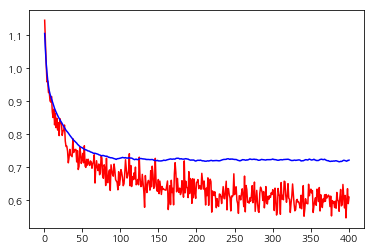

최소 epochs_opt는 386입니다.

- 전체 train데이터셋을 이용해, 최소 epochs까지 러닝...


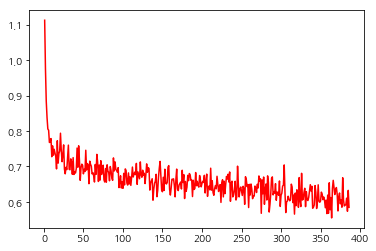


전체 train 데이터로 최적 epoch까지 훈련한 결과 RMSE는 0.49510683531617095 입니다.


- 제출 파일 ./lee-kyung-joon-submission-2019-05-22-16-25-23.csv를 저장했습니다...




- 제출할 예측 데이터의 정보.

         box_off_num
count        243.000
mean     549_989.136
std    1_218_855.404
min           65.480
25%        3_834.292
50%       15_748.027
75%      645_055.469
max   10_838_123.000


노트북 총 소요시간 = 1분 8초



In [144]:
main()

---
# Epilogue
- 최적(최소) epochs 값을 단순히 지정된 범위 내에서 검증 에러가 산술적으로 최소가 되는 epoch으로 프로그래밍적(min)으로 간단히 하다보니, 위 small셋에 대한 검증/학습 에러 그래프에서처럼, 검증에러의 변화폭이 매우 작은 상태로 오래 지속되는 경우에, 이미 오버피팅이 꽤 진행된 epoch지점을 자동으로 골라, 이 지점으로 다시 러닝하는 격이 된다.
- 그래프를 참조해 수동으로 최소 epoch 지점을 강제지정하거나, 변화폭 margin 등을 적용해야 할 것같다.
- 이 노트북에선 배급사별 평균관객수를 대/소로 2등분만 하였는데, 중/ 정도를 더 추가하면 결과에 어떨지도 궁금
- sklearn의 여러 그리레서와 xgboost 등도 적용해보고, stacking도 해봤지만, 이 노트북이 어쨋든 (순간적인, 돌릴때마다 값의 차이가 난다.) 결과가 제일 높게 나왔다. 러닝할 데이터가 예측할 데이터의 2배 정도되는 극히 제한된 데이터 예측 문제라, stacking 등이 큰 효력을 발휘하지 못한거 아닌가...추측함. 물론 stacking 이전에 각 리그레서에 대한 철저한 gridsearch는 하지 못한 이유도 있겠지만.